# 1. Abstract 
In this project , we built a network for the stocks that are part of the  S and P 500 in US stock market based on the correlation of different stock returns for the period between 2007 and 2017. Community
detection techniques were then applied to the constructed
correlation network. The resulting communities were compared for 
consistency with the identified market sections using Standard
Industrial Classification code.We also studied the evolution of the network and the  communities over the study period and found interesting behaviours. Furthermore, we used an open-source
network analysis and visualization software, Gephi, to generate
visualizations of the return correlations among various
public stocks. The visualization results offer a very intuitive
way to look at the overall correlation structure of different
public stocks and evolution of these networks over a period of time  and identify behaviour of key market segments.

# 2. Literature Review

Studies about network analysis for stock market can be classified
into below categories: 

    (1) Applying network analysis techniques for different markets and analyze the topological characteristicsof each market[1]

    (2) Propose different correlation metric analysis among various stock markets to suggest different definitions of edges between stocks and study the impact on the network using different edge definitions[2]

## 2.1. Edge Definition

Approach to construct the edges of stock market network is
not unique. In the current literature, multiple measures were
investigated to construct the edges between nodes: 

    Zero-lag correlation[2]
    Detrended covariance [3]
    Time-lag correlations of prices changes over a certain period of time [4] 

Besides price changes, there have been studies extending the measure
to price-volume cross correlation [5] or only volume changes, as
transaction volume is a good liquidity measure of the company.


## 2.2. Network Properties
Studies have covered both emerging and mature markets. Authors
claim that understanding the topological properties can
help to understand correlation patterns among stocks, thus providing
guidance for risk management. Topological properties
often of interest include degree distribution, clustering and component
structure. In this subcategory study, usually only one
correlation measure is proposed to establish the connections
between nodes. In the introduction session of [1], the author
covered a wide range of previous studies in this category

# 3. Analysis
## 3.1 Data Collection

We collected the prices for the stocks that trade in both NASDAQ and the NYSE stock exchange. The data consisted of closing prices 

In [1]:
## Read S and P 500 list
import pandas as pd
import numpy as np
dfsp500 = pd.read_csv('data/SANDP500.csv')
companies=dfsp500['Symbol'].tolist()
companies=np.random.choice(companies, size=500, replace=False)

In [3]:
import glob
import os
path = r'data/NASDAQ'                     
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NAS   = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NAS=concatenated_df_NAS[concatenated_df_NAS['<ticker>'].isin(companies)]

path = r'data/NYSE'                     
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NYS   = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NYS=concatenated_df_NYS[concatenated_df_NYS['<ticker>'].isin(companies)]

concatenated_df = pd.concat([concatenated_df_NAS,concatenated_df_NYS])

In [4]:
col_p = 'close'
concatenated_df.columns = ['ticker','date','open','high','low','close','vol']
concatenated_df=concatenated_df[concatenated_df['ticker'].isin(companies)]
concatenated_df=concatenated_df.merge(dfsp500,left_on='ticker',right_on='Symbol')
concatenated_df['ticker'] = concatenated_df['ticker']
df_price = concatenated_df[['ticker','date',col_p]]
df_price=df_price.drop_duplicates( keep='last')
df_price['date'] = pd.to_datetime(df_price['date'], format='%Y%m%d', errors='ignore')
df_price.set_index(['date','ticker'],inplace=True)
df_price=df_price.unstack()[col_p]
df_price.reset_index(inplace=True)
df_price.fillna(method='bfill',inplace=True)
df_price.fillna(method='ffill',inplace=True)

In [5]:
import scipy.signal
t = 1
for key in df_price.columns:
    if key not in companies:
        continue
    try:
        df_price[key] = np.log(df_price[key]) - np.log(df_price[key].shift(t))
    except:
        print (key)
df_price.set_index('date',inplace=True)

<IPython.core.display.Javascript object>


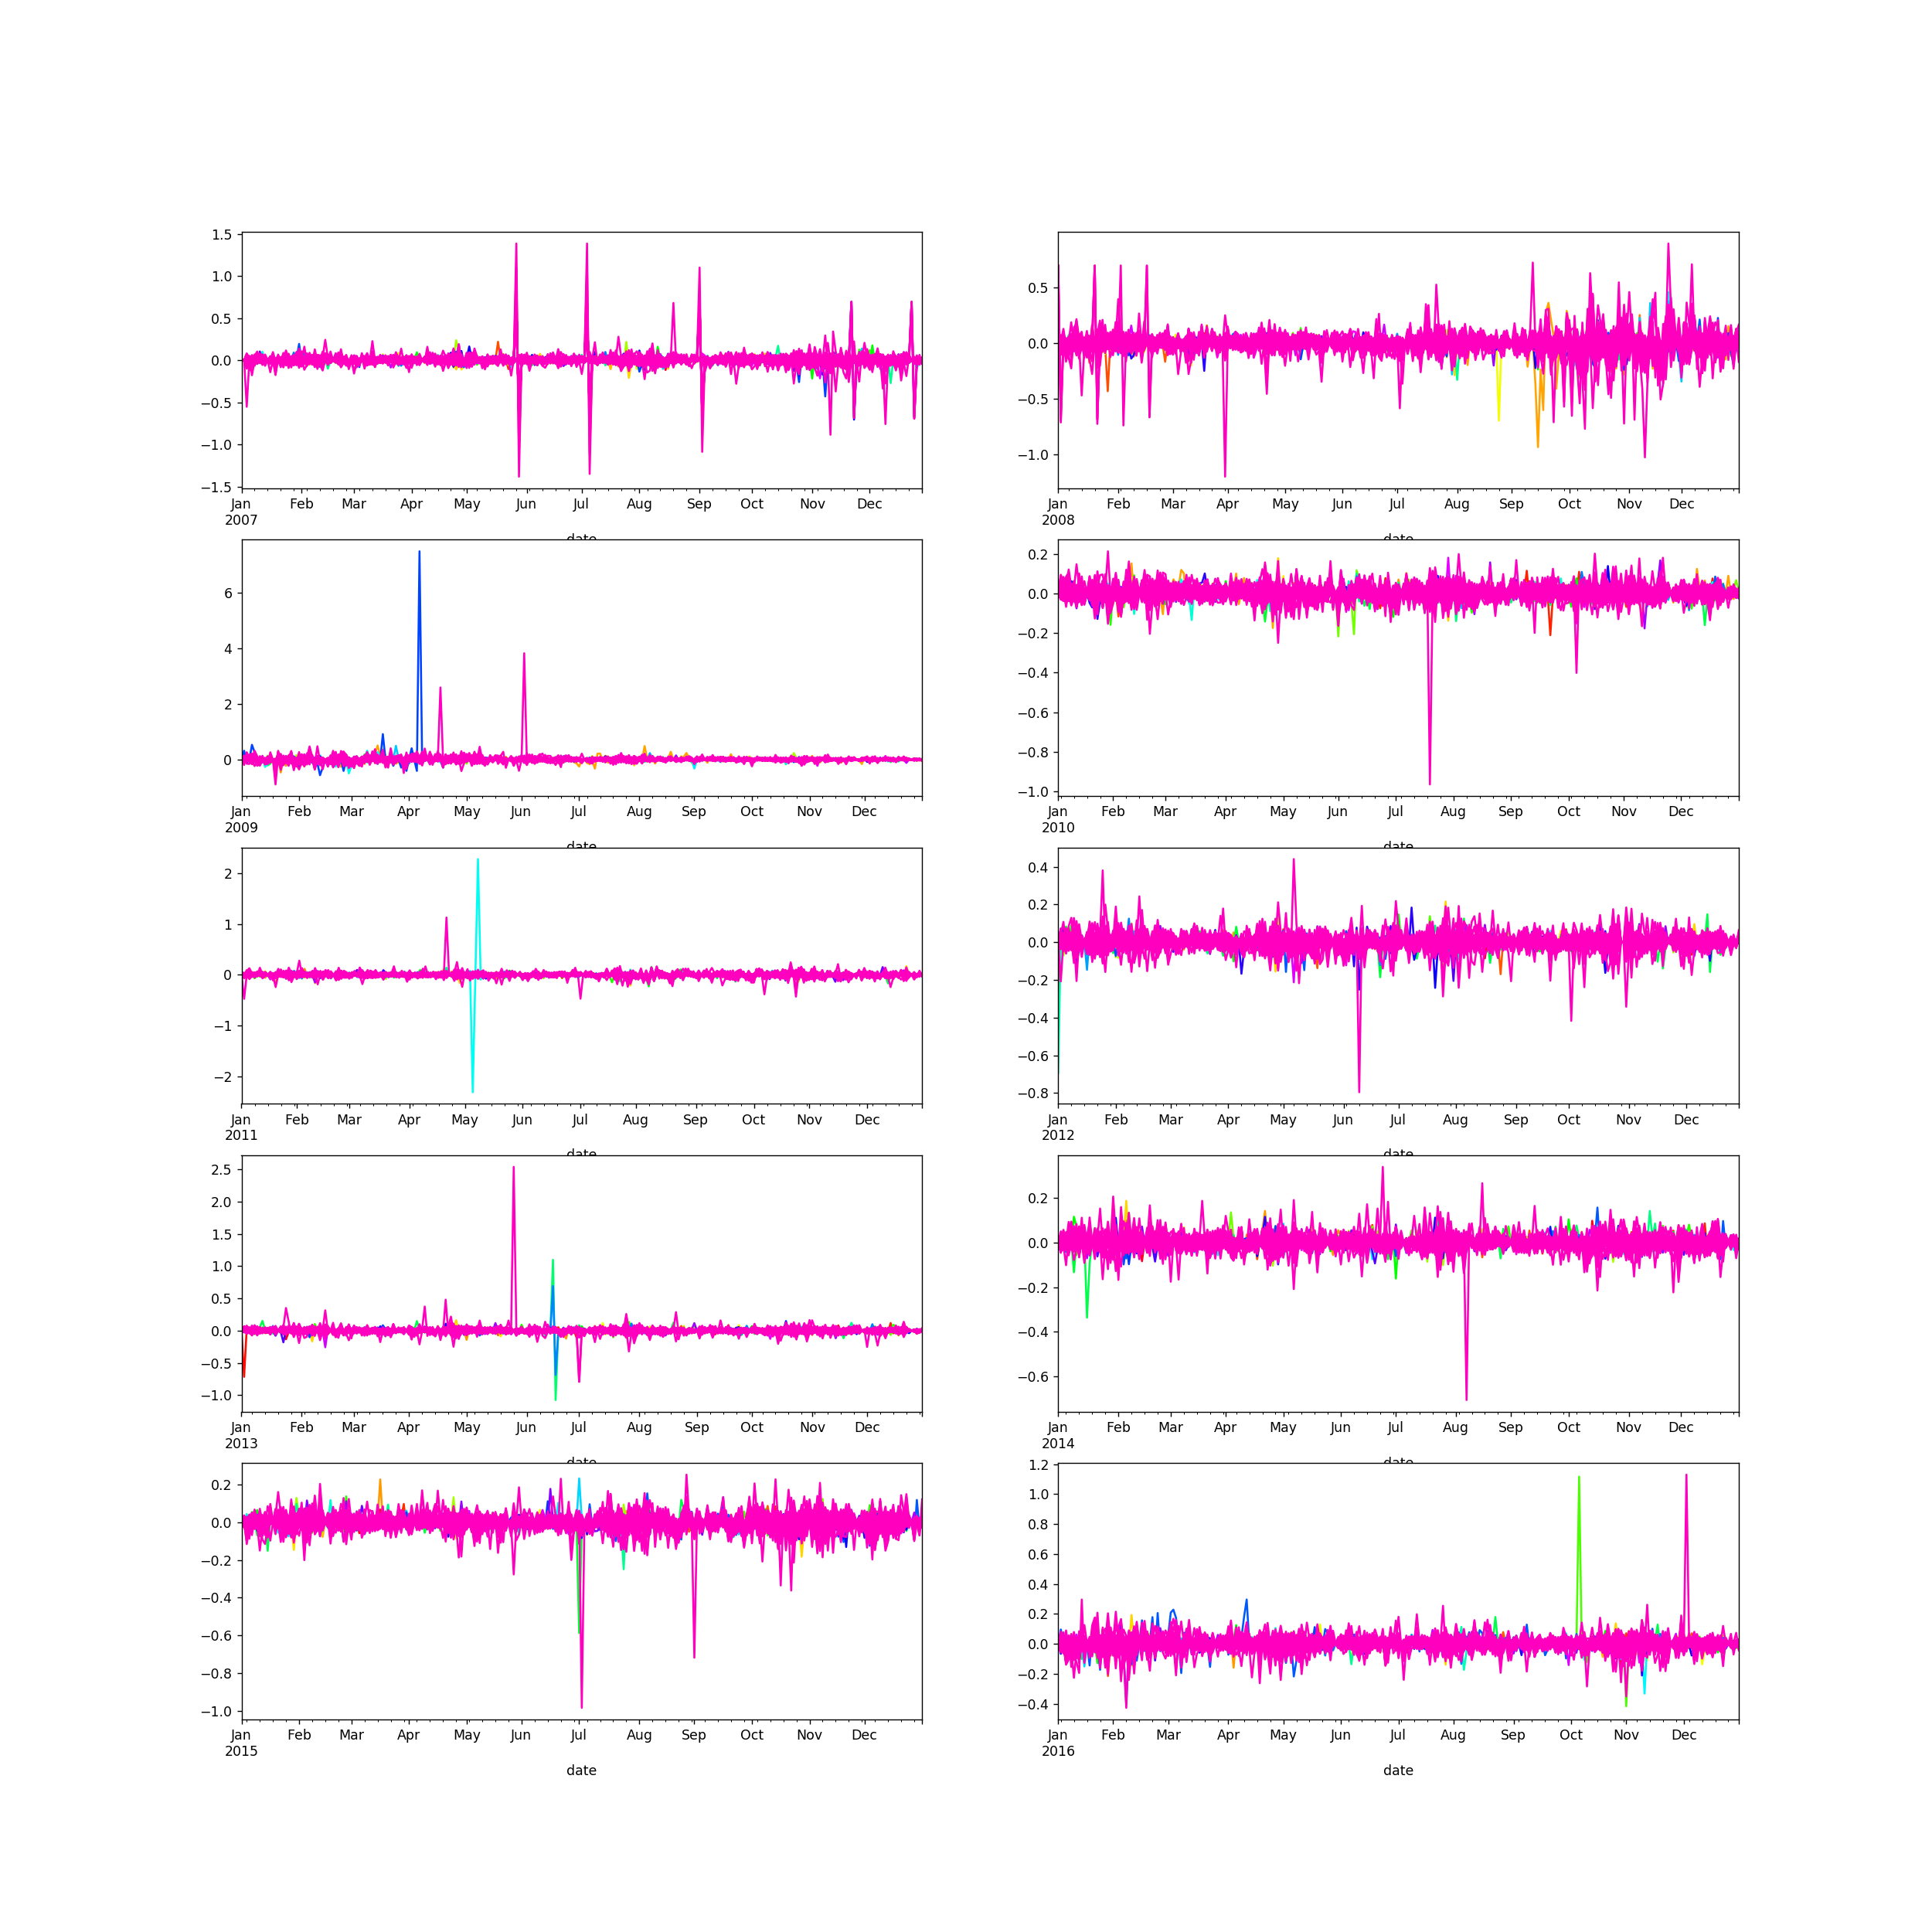

In [54]:
## A quick visualization: stock prices for each sp500 company
import matplotlib.pyplot as plt
%matplotlib notebook
import random as rn
import matplotlib as mpl
NUM_COLORS = len(companies)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(4.*i/NUM_COLORS) for i in range(NUM_COLORS)]
rn.seed = len(companies)  # for choosing random colors
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(20, 20))
y=2007
for row in ax:
    for col in row:
        yfs = str(y) + '0101'
        yfe = str(y) + '1231'
        n = 0
        for i in df_price.columns:
            df_price.loc[yfs:yfe][i].plot(ax=col,color=colors[n])
            n = n + 1
        y = y + 1
plt.show()

<IPython.core.display.Javascript object>


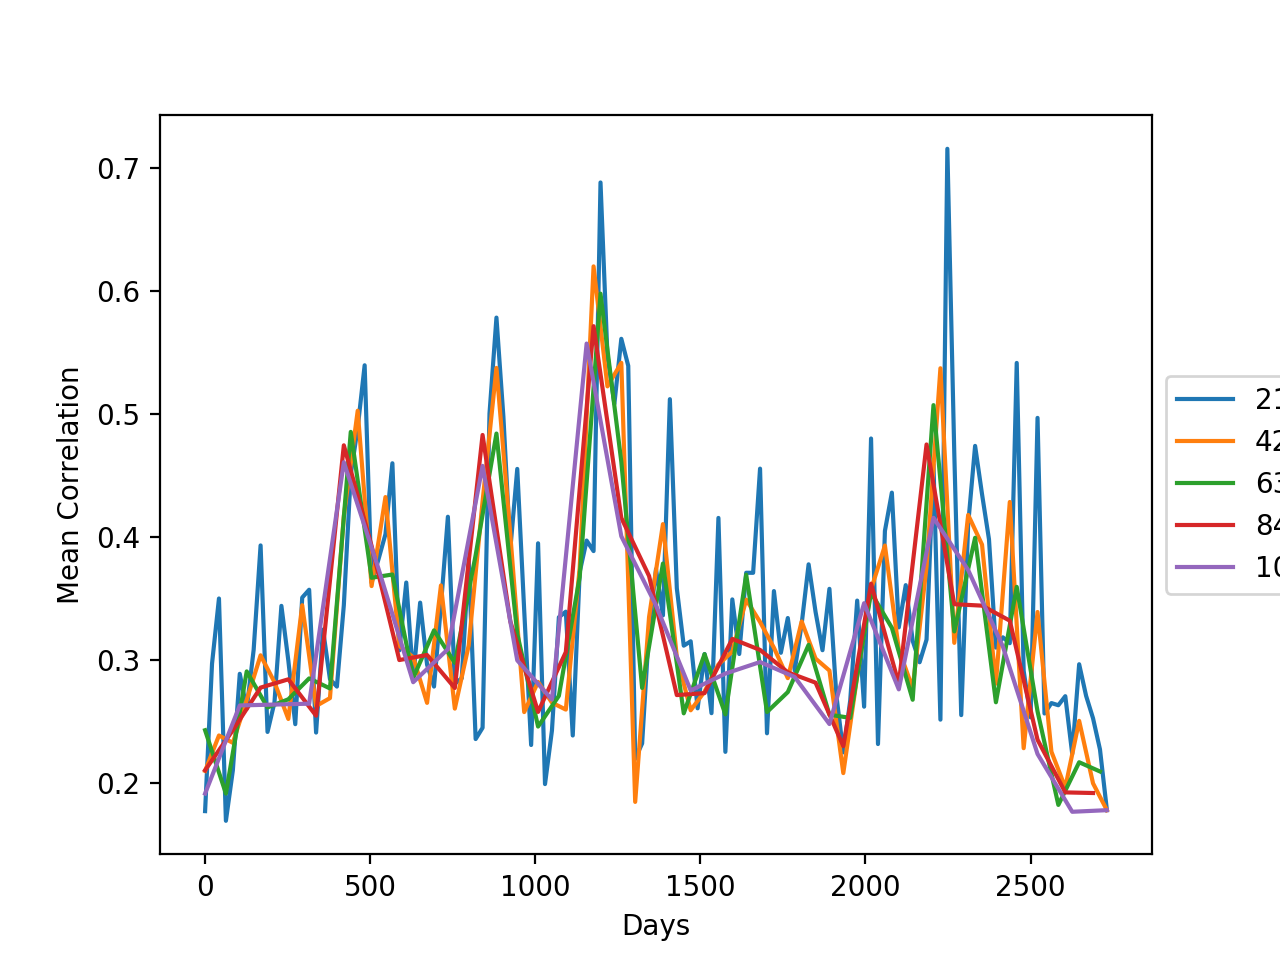

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook
corr_dict = {}
T = 1
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(df_price),W):
            dkey = i
            corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(0,inplace=True)
            x.append(dkey)
            y.append(np.mean([abs(j) for j in corr_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Correlation')
    plt.legend(list(range(21,126,21)), loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
W = 63
corr_dict = {}
for i in range(t,len(df_price),W):
      dkey = i
      corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
      corr_dict[dkey].fillna(0,inplace=True)

In [7]:
import networkx as nx
import community
def get_modularity(y,threshold):
    df_price_corr = corr_dict[y]
    elist = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():    
            if abs(outdict[i][j]) > threshold :
                if i == j :
                    continue
                if i < j:
                    elist.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+W)])
                    #elist.append([i,j,dict(start=y,end=y+1)])
                else:
                    None
    #print (len(elist))
    G=nx.Graph()
    G.add_edges_from(elist)
    #print (nx.info(G))
    partition = community.best_partition(G)
    try:
        m = community.modularity(partition, G)
    except:
        m = 0 
    return m
# This will be our list of fractions to run the simulation over
fractions = np.linspace(0.6, 0.99, 20)
M_list = {}
for y in corr_dict.keys():
    print ('Processing: ' + str(y))
    M_list[y] = [ get_modularity(y, frac)  for frac in fractions ]

Processing: 1
Processing: 64
Processing: 127
Processing: 190
Processing: 253
Processing: 316
Processing: 379
Processing: 442
Processing: 505
Processing: 568
Processing: 631
Processing: 694
Processing: 757
Processing: 820
Processing: 883
Processing: 946
Processing: 1009
Processing: 1072
Processing: 1135
Processing: 1198
Processing: 1261
Processing: 1324
Processing: 1387
Processing: 1450
Processing: 1513
Processing: 1576
Processing: 1639
Processing: 1702
Processing: 1765
Processing: 1828
Processing: 1891
Processing: 1954
Processing: 2017
Processing: 2080
Processing: 2143
Processing: 2206
Processing: 2269
Processing: 2332
Processing: 2395
Processing: 2458
Processing: 2521
Processing: 2584
Processing: 2647
Processing: 2710


<IPython.core.display.Javascript object>


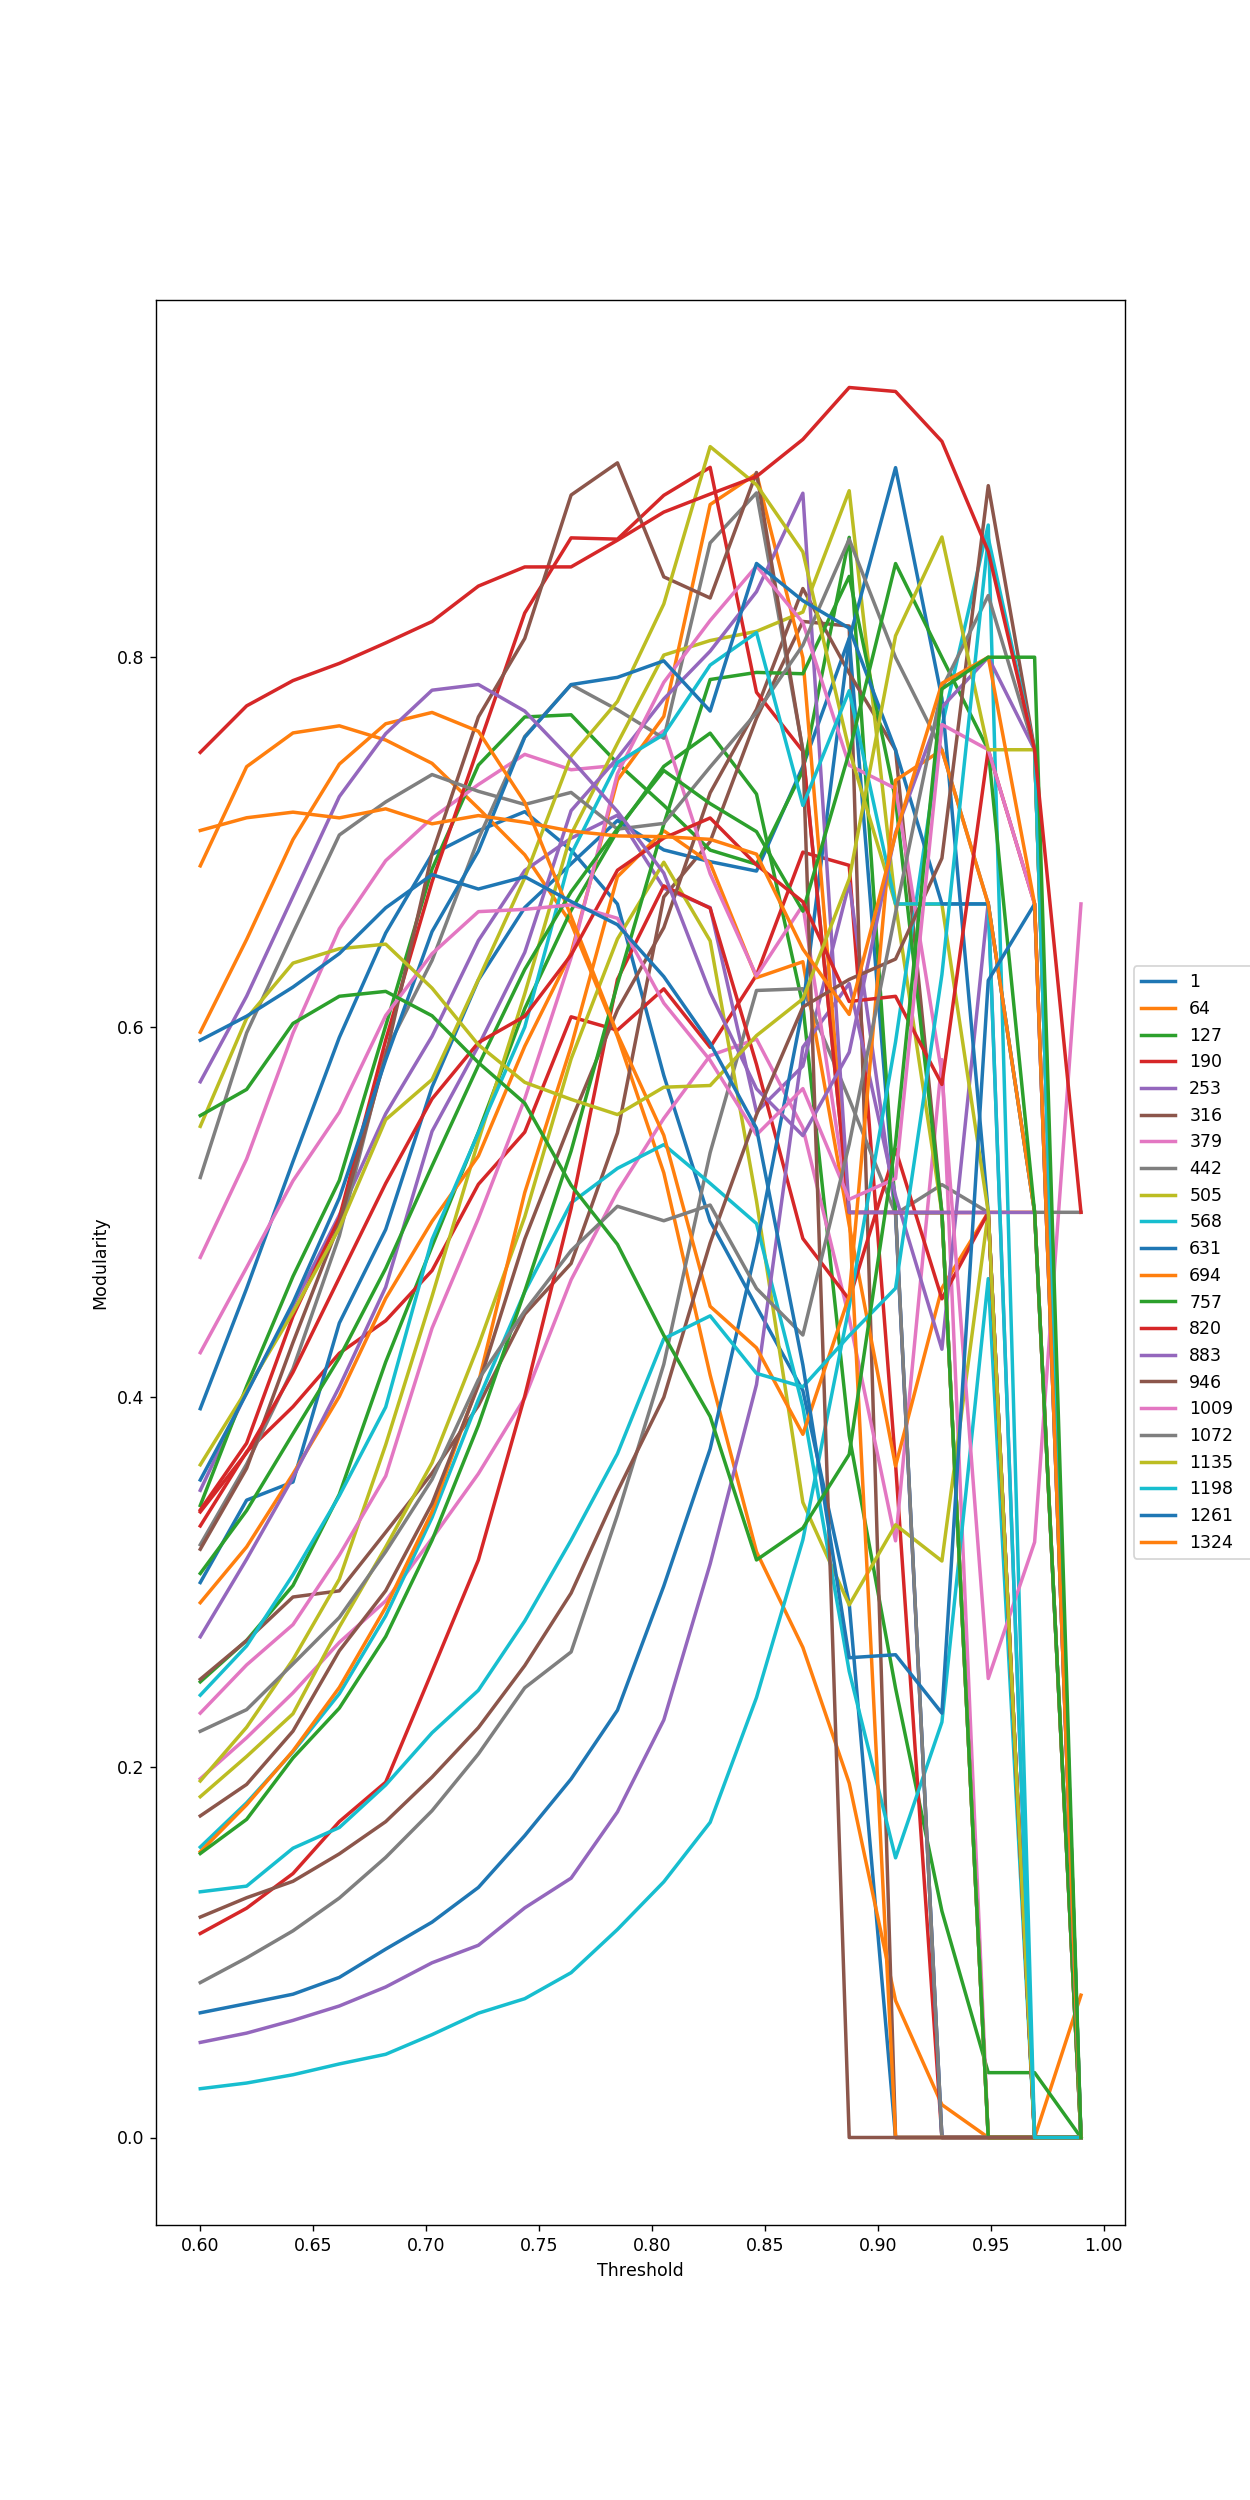

In [57]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(figsize=(10,20))
for y in corr_dict.keys():
    plt.plot(fractions, M_list[y], lw=2)
plt.legend(list(M_list.keys()), loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)
plt.xlabel('Threshold')
plt.ylabel('Modularity')
plt.show()

In [8]:
T_val = {}
for y in M_list.keys():
    val, idx = max((val, idx) for (idx, val) in enumerate(M_list[y]))
    if fractions[idx] > 0.75:
        T_val[y] = 0.75
    else:
        T_val[y] = fractions[idx]
    print (str(y) + ":" + str(T_val[y]))

1:0.743684210526
64:0.661578947368
127:0.75
190:0.75
253:0.75
316:0.75
379:0.75
442:0.75
505:0.75
568:0.75
631:0.75
694:0.75
757:0.75
820:0.75
883:0.75
946:0.75
1009:0.75
1072:0.75
1135:0.75
1198:0.75
1261:0.75
1324:0.75
1387:0.75
1450:0.75
1513:0.75
1576:0.75
1639:0.75
1702:0.75
1765:0.75
1828:0.75
1891:0.75
1954:0.702631578947
2017:0.75
2080:0.75
2143:0.75
2206:0.75
2269:0.75
2332:0.75
2395:0.75
2458:0.75
2521:0.702631578947
2584:0.75
2647:0.75
2710:0.75


In [9]:
elist_dict={}
for y in corr_dict.keys():
    df_price_corr = corr_dict[y]
    threshold = T_val[y]
    elist = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():
            if abs(outdict[i][j]) > threshold :
                if i == j :
                    continue
                if i < j:
                    elist.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+W-1)])
                else:
                    None
    print (str(y) + " :" + str(len(elist)))
    elist_dict[y] = elist

1 :485
64 :931
127 :806
190 :545
253 :768
316 :856
379 :1968
442 :11993
505 :1850
568 :3039
631 :818
694 :851
757 :413
820 :1791
883 :15123
946 :808
1009 :148
1072 :221
1135 :1285
1198 :43409
1261 :8723
1324 :267
1387 :1716
1450 :149
1513 :359
1576 :79
1639 :1131
1702 :331
1765 :274
1828 :378
1891 :293
1954 :751
2017 :1335
2080 :1412
2143 :478
2206 :8575
2269 :1101
2332 :1608
2395 :827
2458 :3399
2521 :1386
2584 :553
2647 :622
2710 :593


In [10]:
# Constructing a graph
import networkx as nx
import community
G_dict = {}
for y in elist_dict.keys():
    G=nx.Graph()
    elist = elist_dict[y]
    G.add_edges_from(elist)
    values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
    for node, value in values.items():
        try:
            G.node[node]['Sector'] = value
        except:
            #name = (value[0:3] + '-' + node)
            #G.add_node(name,Sector=value)
            None
    partition = community.best_partition(G)
    
    deg_cent=dict((k,float(v)) for k,v in nx.degree_centrality(G).items())
    degree = dict((k,float(v)) for k,v in nx.degree(G).items())
    #katz_cent=nx.katz_centrality(G)
    #eigen_cent= dict((k,float(v)) for k,v in nx.eigenvector_centrality(G).items()) 
    close_cent= dict((k,float(v)) for k,v in nx.closeness_centrality(G).items())  
    betw_cent= dict((k,float(v)) for k,v in nx.betweenness_centrality(G).items()) 
    nx.set_node_attributes(G, "community", partition)  
    nx.set_node_attributes(G, "degreecent", deg_cent)
    nx.set_node_attributes(G, "degree", degree)
    #nx.set_node_attributes(G, "katz", katz_cent)
    #nx.set_node_attributes(G, "eigenvector", eigen_cent)
    nx.set_node_attributes(G, "closeness", close_cent)
    nx.set_node_attributes(G, "betweenness", betw_cent)
    nx.set_node_attributes(G, 'start',y)
    nx.set_node_attributes(G, 'end',y+W-1)
    #G.remove_nodes_from(nx.isolates(G)) 
    #T = nx.minimum_spanning_tree(G)
    T = G
    G_dict[y] = T

In [11]:
df_list = []
for k in G_dict.keys():
    G = G_dict[k]
    a = G.node
    df_list.append(pd.DataFrame(a).T.reset_index())
attrib_df = pd.concat(df_list)
attrib_df.fillna(0,inplace=True)
attrib_df1=attrib_df.merge(dfsp500,left_on='index',right_on='Symbol')
attrib_df = attrib_df1[['index','Sector_x','betweenness','closeness','community','degree','degreecent','start','Name']]
attrib_df.columns=['ticker','Sector','Betweeness','Closeness','Community','Degree','DegreeCent','start','Name']

In [14]:
from scipy.stats import linregress
G_val_dict = {}
for Y in G_dict.keys():
    G_val = {}
    G= G_dict[Y]
    G_val['nodes'] =  int(nx.number_of_nodes(G))
    G_val['edges'] =  int(nx.number_of_edges(G))
    #G_val['AvgDegree'] =  nx.average_degree(G)
    G_val['AvgClustering'] = nx.average_clustering(G)
    try:
        G_val['AvgShortestPathLength'] = nx.average_shortest_path_length(G)
    except:
        G_val['AvgShortestPathLength'] = 99999
    try:
        G_val['Diameter'] = nx.diameter(G)
    except:
        G_val['Diameter'] = 99999
    degs = {}
    for n in G.nodes() :
        deg = G.degree(n)
        if deg not in degs.keys() :
            degs[deg] = 0
        degs[deg] += 1
    items = sorted(degs.items())
    x= [k for (k , v ) in items ]
    y= [ v for (k ,v ) in items ]
    xlog= np.array([np.log(k) for (k , v ) in items ])
    ylog= np.array([np.log(v) for (k ,v ) in items ])
    slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
    G_val['Slope'] = slope
    G_val['No of Communities'] = attrib_df.groupby(by=['start'])['Community'].nunique().ix[Y]
    G_val_dict[Y] = G_val
Gvaldf=pd.DataFrame(G_val_dict).T

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


<IPython.core.display.Javascript object>


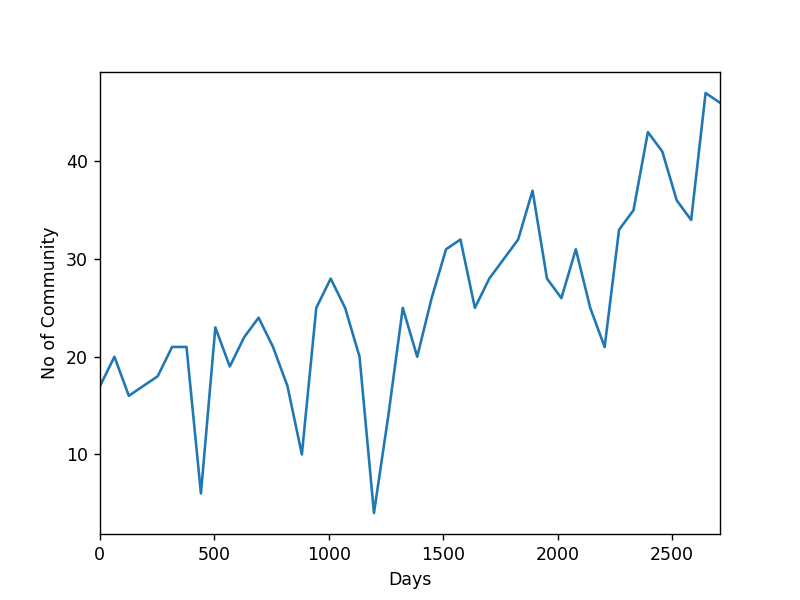

In [63]:
import matplotlib.pyplot as plt
%matplotlib notebook
cdf=attrib_df.groupby(by=['start'])['Community'].nunique()
cdf.plot()
plt.xlabel('Days')
plt.ylabel('No of Community')
plt.show()

<IPython.core.display.Javascript object>


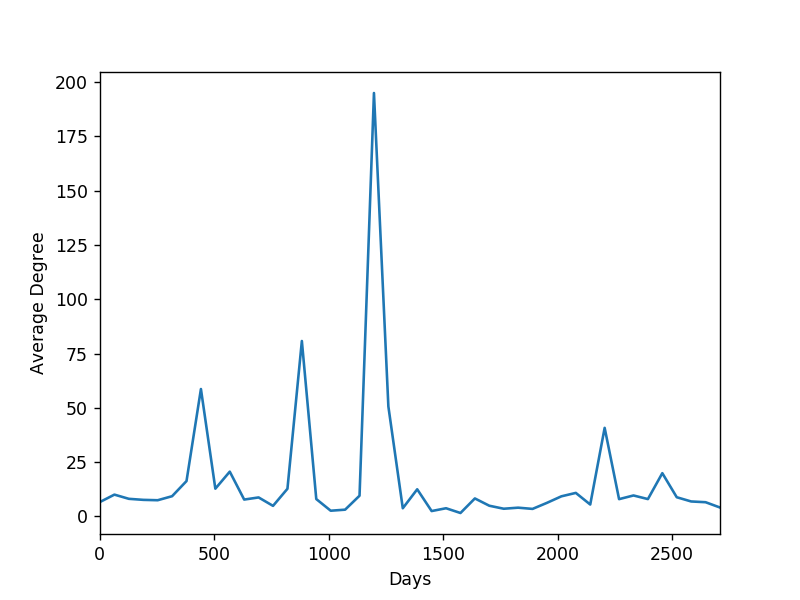

In [64]:
import matplotlib.pyplot as plt
%matplotlib notebook
avgdf=attrib_df.groupby(by=['start'])['Degree'].mean()
avgdf.plot()
plt.xlabel('Days')
plt.ylabel('Average Degree')
plt.show()

In [65]:
#attrib_df.groupby(by=['start','ticker'],as_index=False)['Degree'].sum().nlargest(2,'Degree')
attrib_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Degree','Sector']]

start ticker                                Name  Degree  \
2696   2710    MUR                          Murphy Oil    18.0   
1295   2710    DVN                  Devon Energy Corp.    17.0   
3539   2710    RIG                          Transocean    17.0   
2131   2647    JPM                JPMorgan Chase & Co.    31.0   
2661   2647    MTB                      M&T Bank Corp.    30.0   
3229   2647    PNC              PNC Financial Services    30.0   
495    2584    BAC                Bank of America Corp    24.0   
550    2584    BBT                    BB&T Corporation    23.0   
4207   2584    USB                        U.S. Bancorp    23.0   
2625   2521     MS                      Morgan Stanley    41.0   
7572   2521    DFS         Discover Financial Services    40.0   
1769   2521     GS                 Goldman Sachs Group    37.0   
6340   2458    ETN                   Eaton Corporation   108.0   
8322   2458    MCO                        Moody's Corp   104.0   
833    2458    CMA                       Comerica Inc.    99.0   
2623   2395     MS                      Morgan Stanley    37.0   
2657   2395    MTB                      M&T Bank Corp.    37.0   
3298   2395    PRU                Prudential Financial    35.0   
2622   2332     MS                      Morgan Stanley    68.0   
3224   2332    PNC              PNC Financial Services    60.0   
4025   2332   TROW                 T. Rowe Price Group    59.0   
3910   2269    STI                      SunTrust Banks    42.0   
9716   2269  BRK.B                  Berkshire Hathaway    40.0   
4412   2269    WFC                         Wells Fargo    38.0   
9715   2206  BRK.B                  Berkshire Hathaway   174.0   
211    2206    AMP                Ameriprise Financial   165.0   
8227   2206    HON                Honeywell Int'l Inc.   164.0   
663    2143    BXP                   Boston Properties    20.0   
3471   2143    REG         Regency Centers Corporation    20.0   
1635   2143    FRT     Federal Realty Investment Trust    19.0   
...     ...    ...                                 ...     ...   
152     568    AMG       Affiliated Managers Group Inc    72.0   
4000    568   TROW                 T. Rowe Price Group    70.0   
5488    568    MMM                          3M Company    70.0   
5068    505    EMN                    Eastman Chemical    77.0   
151     505    AMG       Affiliated Managers Group Inc    75.0   
8277    505      L                         Loews Corp.    75.0   
1200    442    DIS             The Walt Disney Company   217.0   
8453    442      A            Agilent Technologies Inc   215.0   
4805    442    BLL                           Ball Corp   202.0   
3813    379    SPG            Simon Property Group Inc    73.0   
1611    379    FRT     Federal Realty Investment Trust    69.0   
2180    379    KIM                        Kimco Realty    69.0   
4174    316    USB                        U.S. Bancorp    49.0   
678     316      C                      Citigroup Inc.    47.0   
1417    316    EQR                  Equity Residential    41.0   
110     253    AIV         Apartment Investment & Mgmt    29.0   
462     253    BAC                Bank of America Corp    29.0   
2632    253    MTB                      M&T Bank Corp.    28.0   
356     190    AVB         AvalonBay Communities, Inc.    29.0   
635     190    BXP                   Boston Properties    28.0   
3307    190    PSA                      Public Storage    28.0   
675     127      C                      Citigroup Inc.    36.0   
3483    127     RF             Regions Financial Corp.    34.0   
4650    127    AIG  American International Group, Inc.    31.0   
1297     64     ED                 Consolidated Edison    25.0   
1220     64    DTE                      DTE Energy Co.    24.0   
3771     64     SO                        Southern Co.    24.0   
513       1    BBT                    BB&T Corporation    23.0   
182       1    AMP                Ameriprise F

<IPython.core.display.Javascript object>


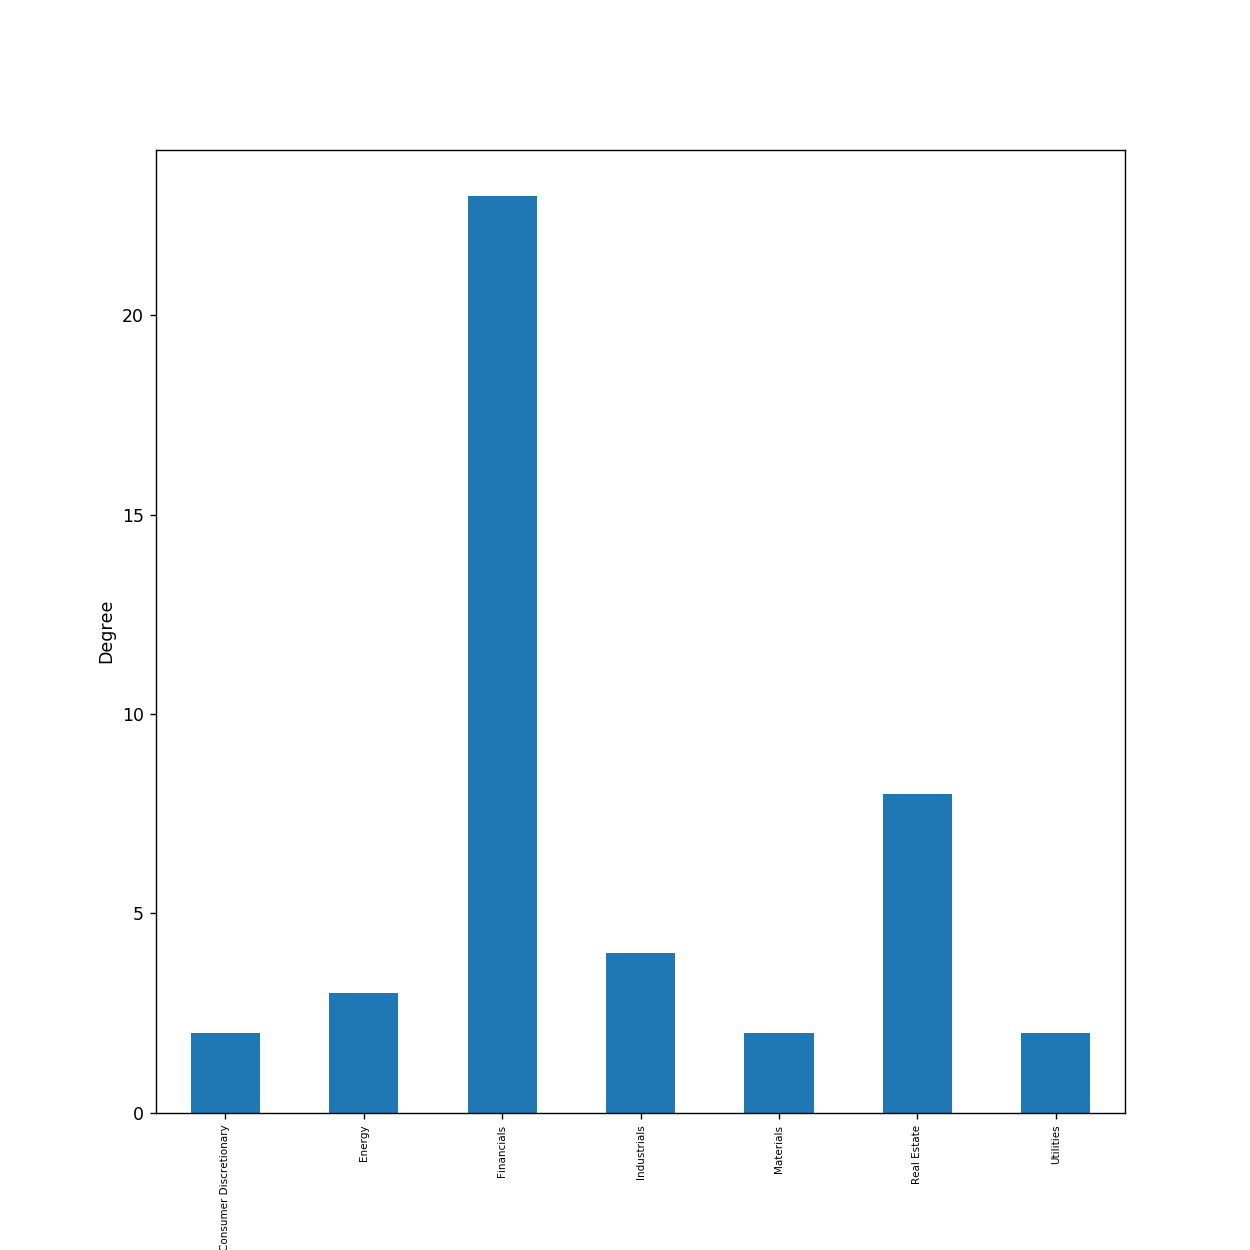

In [66]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(figsize=(10,10))
attrib_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(1).groupby(['Sector']).count()['ticker'].plot(kind='bar')
plt.xticks(rotation=90,fontsize=6)
plt.ylabel('Degree')

In [67]:
attrib_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Betweeness','Sector']]

start ticker                             Name  Betweeness  \
9908   2710   MDLZ           Mondelez International    0.031505   
8858   2710   FISV                       Fiserv Inc    0.027778   
9764   2710    LKQ                  LKQ Corporation    0.022174   
1294   2647    DVN               Devon Energy Corp.    0.009438   
7188   2647    HAL                  Halliburton Co.    0.007599   
6283   2647    DOV                      Dover Corp.    0.007205   
706    2584      C                   Citigroup Inc.    0.004581   
1642   2584    FRT  Federal Realty Investment Trust    0.003143   
4129   2584    UNM                       Unum Group    0.002644   
7960   2521    MMC                 Marsh & McLennan    0.262719   
8638   2521    BDX                 Becton Dickinson    0.248392   
8471   2521      A         Agilent Technologies Inc    0.242796   
6280   2458    DOV                      Dover Corp.    0.078728   
1942   2458    HES                 Hess Corporation    0.056802   
6340   2458    ETN                Eaton Corporation    0.029165   
178    2395    AMG    Affiliated Managers Group Inc    0.004089   
3985   2395    TMK                  Torchmark Corp.    0.003010   
2657   2395    MTB                   M&T Bank Corp.    0.002594   
7025   2332    CAT                 Caterpillar Inc.    0.092098   
2005   2332     HP                Helmerich & Payne    0.086972   
5252   2332    FMC                  FMC Corporation    0.079971   
9716   2269  BRK.B               Berkshire Hathaway    0.064692   
176    2269    AMG    Affiliated Managers Group Inc    0.061541   
4546   2269    XOM                Exxon Mobil Corp.    0.050326   
6336   2206    ETN                Eaton Corporation    0.056043   
8227   2206    HON             Honeywell Int'l Inc.    0.046284   
1287   2206    DVN               Devon Energy Corp.    0.041768   
1975   2143    HIG       Hartford Financial Svc.Gp.    0.068691   
699    2143      C                   Citigroup Inc.    0.062822   
7954   2143    MMC                 Marsh & McLennan    0.052631   
...     ...    ...                              ...         ...   
5488    568    MMM                       3M Company    0.040593   
9589    568   NWSA               News Corp. Class A    0.034357   
8861    568    FLS            Flowserve Corporation    0.030804   
5068    505    EMN                 Eastman Chemical    0.087151   
8277    505      L                      Loews Corp.    0.086198   
151     505    AMG    Affiliated Managers Group Inc    0.067480   
8453    442      A         Agilent Technologies Inc    0.027645   
1200    442    DIS          The Walt Disney Company    0.027131   
5836    442    SWK           Stanley Black & Decker    0.026853   
1718    379    GPC                    Genuine Parts    0.042388   
2061    379    ITW              Illinois Tool Works    0.038355   
714     379    CCL                   Carnival Corp.    0.034984   
5126    316   EXPD                 Expeditors Int'l    0.066753   
678     316      C                   Citigroup Inc.    0.036318   
420     316    AXP              American Express Co    0.033278   
6395    253     GE                 General Electric    0.166172   
462     253    BAC             Bank of America Corp    0.140309   
4522    253    XOM                Exxon Mobil Corp.    0.133325   
461     190    BAC             Bank of America Corp    0.034769   
1776    190   HBAN            Huntington Bancshares    0.031366   
4172    190    USB                     U.S. Bancorp    0.031252   
515     127    BBT                 BB&T Corporation    0.115026   
3952    127    TMK                  Torchmark Corp.    0.092624   
5832    127    SWK           Stanley Black & Decker    0.089674   
5791     64    STT               State Street Corp.    0.086084   
4519     64    XOM                Exxon Mobil Corp.    0.062259   
3262     64    PRU             Prudential Financial    0.041616   
182       1    AMP             Ameriprise Financial  

<IPython.core.display.Javascript object>


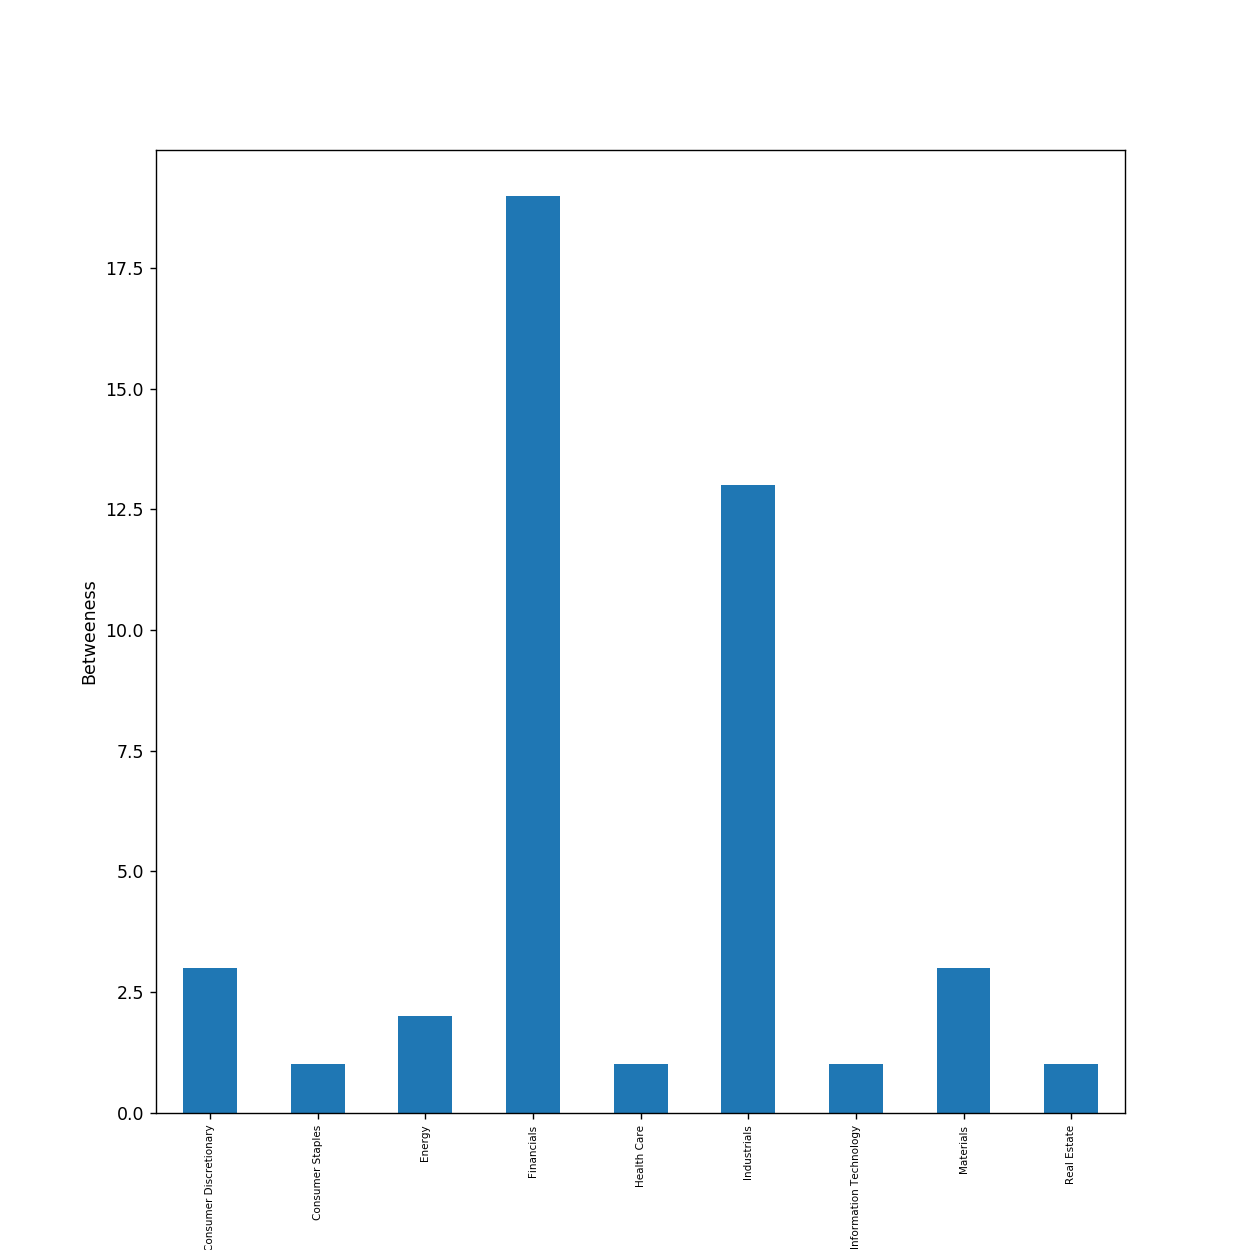

In [68]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(figsize=(10,10))
attrib_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(1).groupby(['Sector']).count()['ticker'].plot(kind='bar')
plt.xticks(rotation=90,fontsize=6)
plt.ylabel('Betweeness')

In [69]:
cmatrix = attrib_df.groupby(by=['start','Community','ticker'])['ticker'].count().unstack()
cmatrix.fillna(0,inplace=True)
smatrix = attrib_df.groupby(by=['Sector','ticker'])['ticker'].count().unstack()
smatrix.fillna(0,inplace=True)
smatrix[smatrix != 0] = 1
csmatrix=pd.concat([smatrix,cmatrix])
jval = {}
for idxs,rows  in smatrix.iterrows():
    xlist = []
    ylist = []
    for idxc,rowc in cmatrix.iterrows():
        x = [int(i) for i in rows]
        y = [int(i) for i in rowc]
        jc = (np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum()))
        if jc > 0.25:
            xlist.append(idxc[0])
            ylist.append(jc)
            print (str(idxs) + "-" + str(idxc) + str(jc))
    jval[idxs] = [xlist,ylist]

Consumer Discretionary-(253, 9)0.288888888889
Consumer Discretionary-(379, 0)0.317757009346
Consumer Discretionary-(820, 0)0.266129032258
Consumer Staples-(1639, 3)0.5
Consumer Staples-(2269, 4)0.315789473684
Consumer Staples-(2521, 9)0.380952380952
Energy-(1, 6)0.705882352941
Energy-(64, 7)0.617647058824
Energy-(190, 5)0.538461538462
Energy-(253, 10)0.552631578947
Energy-(316, 9)0.657142857143
Energy-(379, 10)0.675
Energy-(442, 2)0.285714285714
Energy-(505, 3)0.810810810811
Energy-(568, 1)0.885714285714
Energy-(631, 1)0.692307692308
Energy-(694, 2)0.756756756757
Energy-(757, 2)0.595238095238
Energy-(820, 3)0.454545454545
Energy-(1072, 10)0.294117647059
Energy-(1135, 7)0.771428571429
Energy-(1387, 2)0.478260869565
Energy-(1450, 5)0.470588235294
Energy-(1639, 7)0.527777777778
Energy-(1954, 10)0.676470588235
Energy-(2017, 8)0.586956521739
Energy-(2080, 8)0.527777777778
Energy-(2143, 8)0.441176470588
Energy-(2206, 6)0.783783783784
Energy-(2269, 10)0.525
Energy-(2332, 13)0.617647058824
Ene

<IPython.core.display.Javascript object>


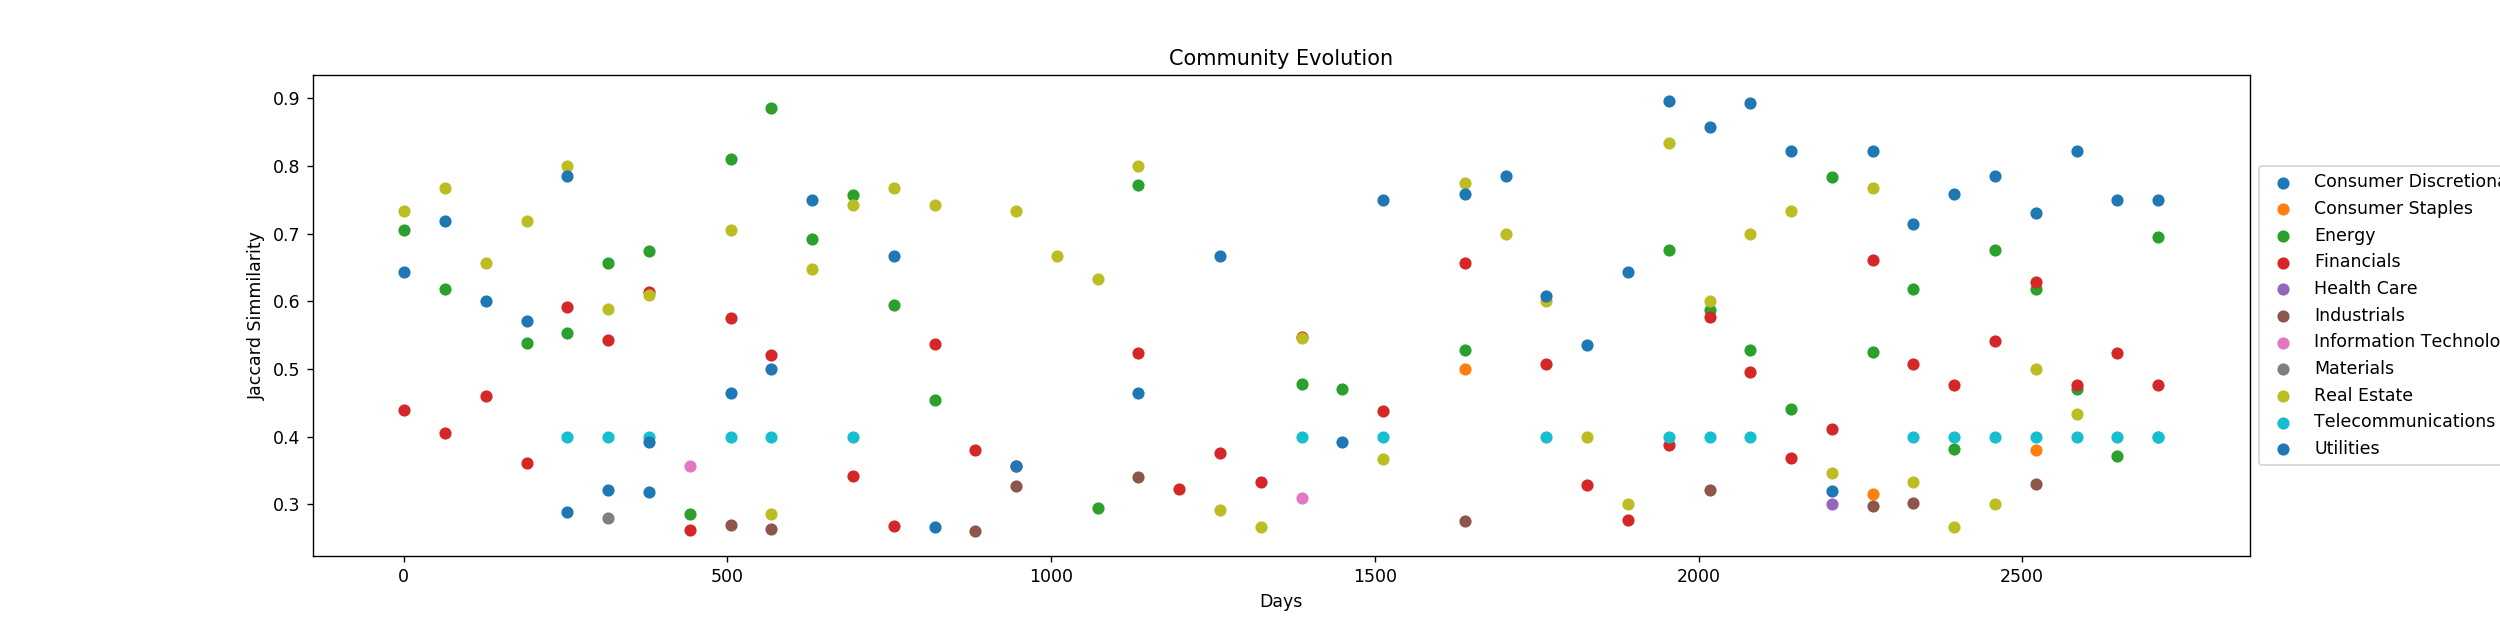

In [70]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(figsize=(20,5))
for key in jval:
    x = jval[key][0]
    y = jval[key][1]
    plt.scatter(x,y)
plt.legend(list(jval.keys()), loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Days')
plt.ylabel('Jaccard Simmilarity')
plt.title('Community Evolution')
plt.show()

<IPython.core.display.Javascript object>


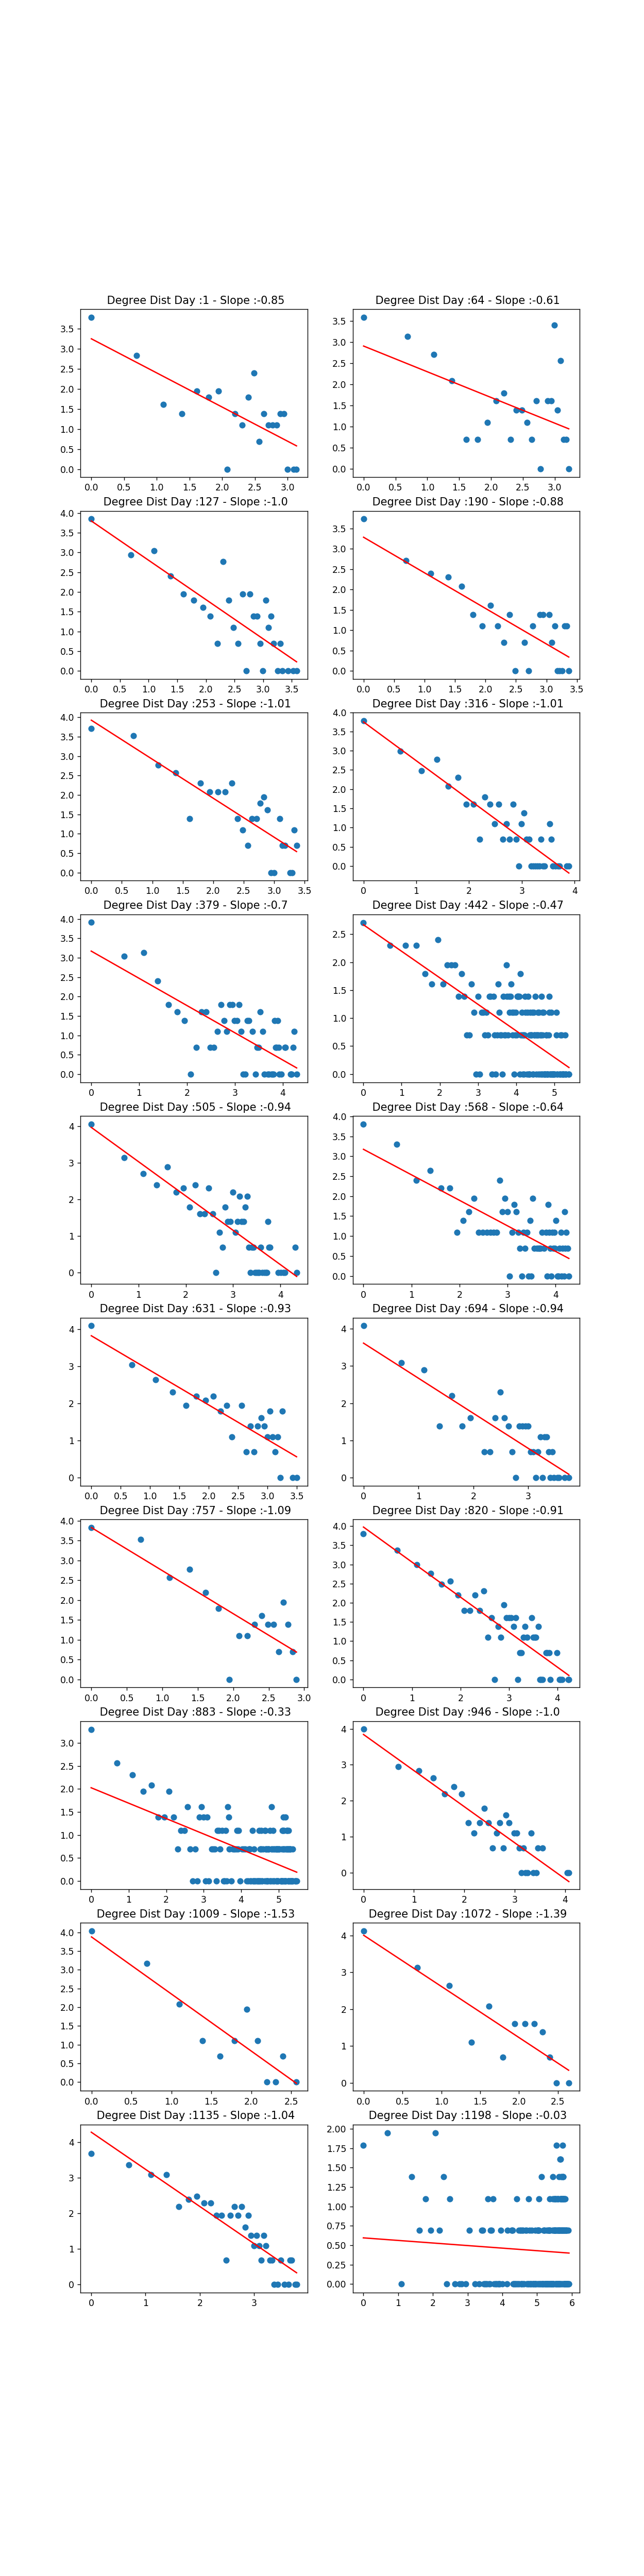

In [71]:
## Explore graph properties
import matplotlib.pyplot as plt
from scipy.stats import linregress
fig, ax = plt.subplots(nrows=10,ncols=2,figsize=(10, 40))
Y = 1
for row in ax:
    for col in row:
        degs = {}
        for n in G_dict[Y].nodes() :
            deg = G_dict[Y].degree(n)
            if deg not in degs.keys() :
                degs[deg] = 0
            degs[deg] += 1
        items = sorted(degs.items())
        x= [k for (k , v ) in items ]
        y= [ v for (k ,v ) in items ]
        xlog= np.array([np.log(k) for (k , v ) in items ])
        ylog= np.array([np.log(v) for (k ,v ) in items ])
        col.scatter(xlog, ylog)
        slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
        col.plot(xlog, (slope * xlog + intercept), color='red')
        #ax.set_xscale( 'log' )
        #ax.set_yscale( 'log' )
        col.set_title ( " Degree Dist Day :" + str(Y) + " - Slope :" + str(round(slope,2) ))
        Y = Y + W
plt.show()

<IPython.core.display.Javascript object>


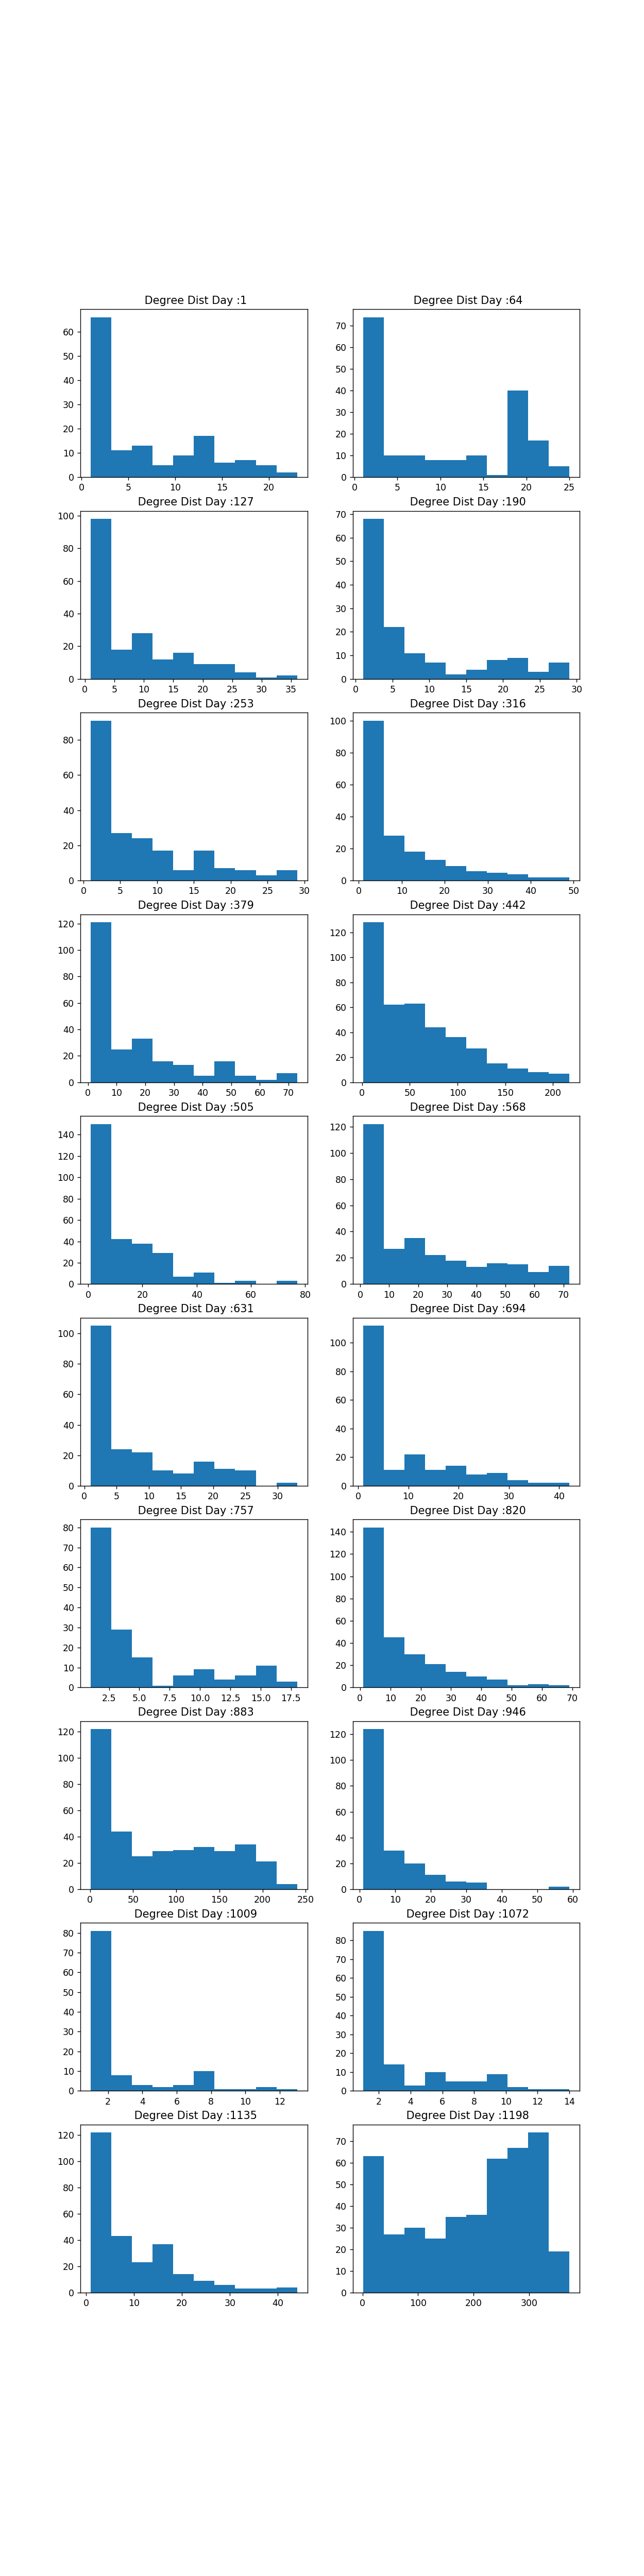

In [72]:
## Explore graph properties
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=10,ncols=2,figsize=(10, 40))
y = 1
for row in ax:
    for col in row:
        deg_dist = [v for k,v in nx.degree(G_dict[y]).items()]
        deg_dist.sort(reverse=True)
        pdf, bins, patch = col.hist(deg_dist, bins=10)
        col.set_title ( " Degree Dist Day :" + str(y) )
        y = y + W
plt.show()


In [ ]:
## Explore graph properties
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(40, 40))
y = 0
for row in ax:
    for col in row:
        col.axis('off')
        try:
            T = G_dict[list(G_dict.keys())[y]]
        except:
            continue
        col.set_title( str(list(G_dict.keys())[y]) )
        col.axis('off')
        #Gcc=sorted(nx.connected_component_subgraphs(T), key = len, reverse=True)[0]
        #pos=nx.spring_layout(Gcc)
        #nx.draw_networkx_nodes(Gcc,pos,ax=col,node_size=20)
        #nx.draw_networkx_edges(Gcc,pos,ax=col,alpha=0.4)
        color=nx.get_node_attributes(T,'community')
        values = [color.get(node) for node in T.nodes()]
        nx.draw(T,ax=col,pos=nx.spring_layout(T,k=0.20),with_labels = True,node_color = values,cmap = plt.get_cmap('jet'))
        y = y + 1
plt.show()

In [15]:
# Constructing a graph
import networkx as nx
M=nx.MultiGraph()
for y in G_dict.keys():
    M.add_nodes_from(G_dict[y].nodes(data=True))
    M.add_edges_from(G_dict[y].edges(data=True))
nx.write_gexf(M,'data/price-sp500.gexf')

In [17]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/price-sp500.gexf')
root = tree.getroot()
for element in root.iter("{http://www.gexf.net/1.1draft}node"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child.remove(child[0])
        for y in G_dict.keys():
            T = G_dict[y]
            n = 0
            try:
                for att in T.node[noden]:
                    new = ET.Element("{http://www.gexf.net/1.1draft}attvalue")
                    new.set('for',str(n))
                    new.set('value',str(T.node[noden][att]))
                    new.set('start',str(y))
                    new.set('end',str(y+W-1))
                    child.append(new)
                    #print (T.node[noden][att])
                    n = n + 1
            except:
                continue
tree.write('data/price-sp500-o.gexf')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

f, ax = plt.subplots(111)
corr = corr_dict[2011]
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

<IPython.core.display.Javascript object>


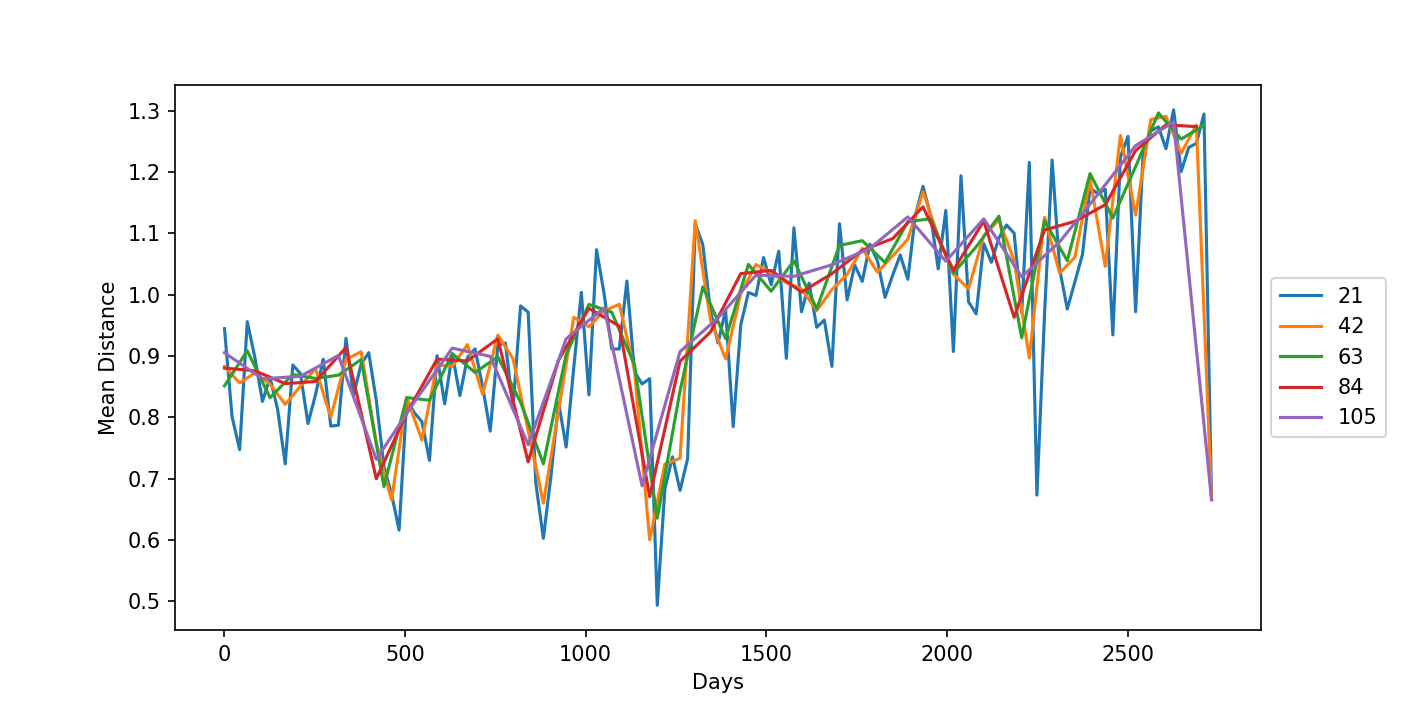

In [20]:
import math
import matplotlib.pyplot as plt
%matplotlib notebook
def calc_d(x):
    x = round(x,3)
    d = math.sqrt(2 * (1 - x))
    return d
corr_dict = {}
corr_dist_dict = {}
T = 1
W = 63
x = []
y = []
for w in range(21,126,21):
    x = []
    y = []
    W = w
    for i in range(t,len(df_price),W):
            dkey = i
            corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
            corr_dict[dkey].fillna(1,inplace=True)
            corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)
            x.append(dkey)
            y.append(np.mean([abs(j) for j in corr_dist_dict[dkey].values.flatten().tolist()]))
    plt.plot(x,y)
    plt.xlabel('Days')
    plt.ylabel('Mean Distance')
    plt.legend(list(range(21,126,21)), loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
W = 63
corr_dict = {}
corr_dist_dict = {}
for i in range(t,len(df_price),W):
      dkey = i
      corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
      corr_dict[dkey].fillna(1,inplace=True)
      corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)

In [41]:
#MST Start 
elistmst_dict={}
for y in corr_dist_dict.keys():
    df_price_corr = corr_dist_dict[y]
    elistmst = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():
            if abs(outdict[i][j]) > 0:
                elistmst.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+W-1)])
    print (len(elistmst))
    elistmst_dict[y] = elistmst

184470
186192
188790
190532
190532
194040
195806
197580
201152
201152
200256
201152
201152
202950
203852
205662
207480
209306
210222
211140
219492
217622
219492
220430
220430
221370
226098
226100
229920
229920
231842
232806
233772
236682
235710
241572
243542
244530
246512
247506
247506
248502
247506
247506


In [42]:
import networkx as nx
import community
GMST_dict = {}
for y in elistmst_dict.keys():
    print ('Processing : ' + str(y))
    G=nx.Graph()
    elist = elistmst_dict[y]
    G.add_edges_from(elist)
    T = nx.minimum_spanning_tree(G)
    G = T
    values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
    for node, value in values.items():
        try:
            G.node[node]['Sector'] = value
        except:
            #name = (value[0:3] + '-' + node)
            #G.add_node(name,Sector=value)
            None
    partition = community.best_partition(G)
    
    deg_cent=dict((k,float(v)) for k,v in nx.degree_centrality(G).items())
    degree = dict((k,float(v)) for k,v in nx.degree(G).items())
    #katz_cent=nx.katz_centrality(G)
    #eigen_cent= dict((k,float(v)) for k,v in nx.eigenvector_centrality(G).items()) 
    close_cent= dict((k,float(v)) for k,v in nx.closeness_centrality(G).items())  
    betw_cent= dict((k,float(v)) for k,v in nx.betweenness_centrality(G).items()) 
    nx.set_node_attributes(G, "community", partition)  
    nx.set_node_attributes(G, "degreecent", deg_cent)
    nx.set_node_attributes(G, "degree", degree)
    #nx.set_node_attributes(G, "katz", katz_cent)
    #nx.set_node_attributes(G, "eigenvector", eigen_cent)
    nx.set_node_attributes(G, "closeness", close_cent)
    nx.set_node_attributes(G, "betweenness", betw_cent)
    nx.set_node_attributes(G, 'start',y)
    nx.set_node_attributes(G, 'end',y+W)
    #G.remove_nodes_from(nx.isolates(G)) 
    #T = nx.minimum_spanning_tree(G)
    T = G
    GMST_dict[y] = T

Processing : 1
Processing : 64
Processing : 127
Processing : 190
Processing : 253
Processing : 316
Processing : 379
Processing : 442
Processing : 505
Processing : 568
Processing : 631
Processing : 694
Processing : 757
Processing : 820
Processing : 883
Processing : 946
Processing : 1009
Processing : 1072
Processing : 1135
Processing : 1198
Processing : 1261
Processing : 1324
Processing : 1387
Processing : 1450
Processing : 1513
Processing : 1576
Processing : 1639
Processing : 1702
Processing : 1765
Processing : 1828
Processing : 1891
Processing : 1954
Processing : 2017
Processing : 2080
Processing : 2143
Processing : 2206
Processing : 2269
Processing : 2332
Processing : 2395
Processing : 2458
Processing : 2521
Processing : 2584
Processing : 2647
Processing : 2710


In [43]:
df_list = []
for k in GMST_dict.keys():
    G = GMST_dict[k]
    a = G.node
    df_list.append(pd.DataFrame(a).T.reset_index())
attribMST_df = pd.concat(df_list)
attribMST_df.fillna(0,inplace=True)
attribMST_df1=attribMST_df.merge(dfsp500,left_on='index',right_on='Symbol')
attribMST_df = attribMST_df1[['index','Sector_x','betweenness','closeness','community','degree','degreecent','start','Name']]
attribMST_df.columns=['ticker','Sector','Betweeness','Closeness','Community','Degree','DegreeCent','start','Name']

In [44]:
from scipy.stats import linregress
G_valMST_dict = {}
for Y in GMST_dict.keys():
    G_val = {}
    G= GMST_dict[Y]
    G_val['nodes'] =  nx.number_of_nodes(G)
    G_val['edges'] =  nx.number_of_edges(G)
    #G_val['AvgDegree'] =  nx.average_degree(G)
    G_val['AvgClustering'] = nx.average_clustering(G)
    try:
        G_val['AvgShortestPathLength'] = nx.average_shortest_path_length(G)
    except:
        G_val['AvgShortestPathLength'] = 99999
    try:
        G_val['Diameter'] = nx.diameter(G)
    except:
        G_val['Diameter'] = 99999
    degs = {}
    for n in G.nodes() :
        deg = G.degree(n)
        if deg not in degs.keys() :
            degs[deg] = 0
        degs[deg] += 1
    items = sorted(degs.items())
    x= [k for (k , v ) in items ]
    y= [ v for (k ,v ) in items ]
    xlog= np.array([np.log(k) for (k , v ) in items ])
    ylog= np.array([np.log(v) for (k ,v ) in items ])
    slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
    G_val['Slope'] = slope
    G_val['No of Communities'] = attribMST_df.groupby(by=['start'])['Community'].nunique().ix[Y]
    G_valMST_dict[Y] = G_val
GMST_df=pd.DataFrame(G_valMST_dict).T
GMST_df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


AvgClustering  AvgShortestPathLength  Diameter  No of Communities  \
1               0.0               9.993788      25.0               25.0   
64              0.0              12.010387      29.0               24.0   
127             0.0              12.534986      29.0               27.0   
190             0.0              12.842084      33.0               23.0   
253             0.0              13.076963      30.0               25.0   
316             0.0              13.303463      35.0               25.0   
379             0.0              11.705852      37.0               23.0   
442             0.0              10.024011      24.0               23.0   
505             0.0              11.790288      29.0               25.0   
568             0.0              12.183085      29.0               26.0   
631             0.0              12.375090      32.0               24.0   
694             0.0              12.037623      28.0               25.0   
757             0.0              10.392698      26.0               24.0   
820             0.0              10.758591      25.0               23.0   
883             0.0               9.384190      25.0               25.0   
946             0.0               7.388949      19.0               25.0   
1009            0.0              11.581897      27.0               23.0   
1072            0.0               9.934784      27.0               23.0   
1135            0.0              11.277811      27.0               24.0   
1198            0.0              10.075590      24.0               24.0   
1261            0.0               9.418002      22.0               26.0   
1324            0.0              10.242365      25.0               24.0   
1387            0.0              10.257813      26.0               25.0   
1450            0.0               9.356385      24.0               22.0   
1513            0.0              11.731461      30.0               25.0   
1576            0.0               9.295587      27.0               23.0   
1639            0.0              10.863043      31.0               25.0   
1702            0.0              10.194118      26.0               26.0   
1765            0.0               9.378993      24.0               25.0   
1828            0.0              10.142571      25.0               23.0   
1891            0.0              13.293286      41.0               25.0   
1954            0.0              12.965061      38.0               24.0   
2017            0.0              12.735212      34.0               25.0   
2080            0.0              11.508454      32.0               24.0   
2143            0.0              12.055416      42.0               26.0   
2206            0.0              11.750815      30.0               26.0   
2269            0.0              14.480155      38.0               26.0   
2332            0.0              11.984509      29.0               24.0   
2395            0.0              15.071461      34.0               24.0   
2458            0.0              12.400410      32.0               25.0   
2521            0.0              16.662036      47.0               25.0   
2584            0.0              14.754425      34.0               24.0   
2647            0.0              14.434931      42.0               27.0   
2710            0.0              15.012977      34.0               26.0   

         Slope  edges  nodes  
1    -2.424250  429.0  430.0  
64   -2.423136  431.0  432.0  
127  -2.449242  434.0  435.0  
190  -2.456956  436.0  437.0  
253  -2.440426  436.0  437.0  
316  -2.284915  440.0  441.0  
379  -2.392109  442.0  443.0  
442  -2.179947  444.0  445.0  
505  -2.411162  448.0  449.0  
568  -2.319800  448.0  449.0  
631  -2.087519  447.0  448.0  
694  -2.466842  448.0  449.0  
757  -2.211853  448.0  449.0  
820  -2.285096  450.0  451.0  
883  -2.194057  451.0  452.0  
946  -2.239048  453.0  454.0  
1009 -2.425907  455.0  456.0  
1072 -2.208544  457.0  458.0  
1135 -2.312508  458.0  459.0  
1198 -2.20

<IPython.core.display.Javascript object>


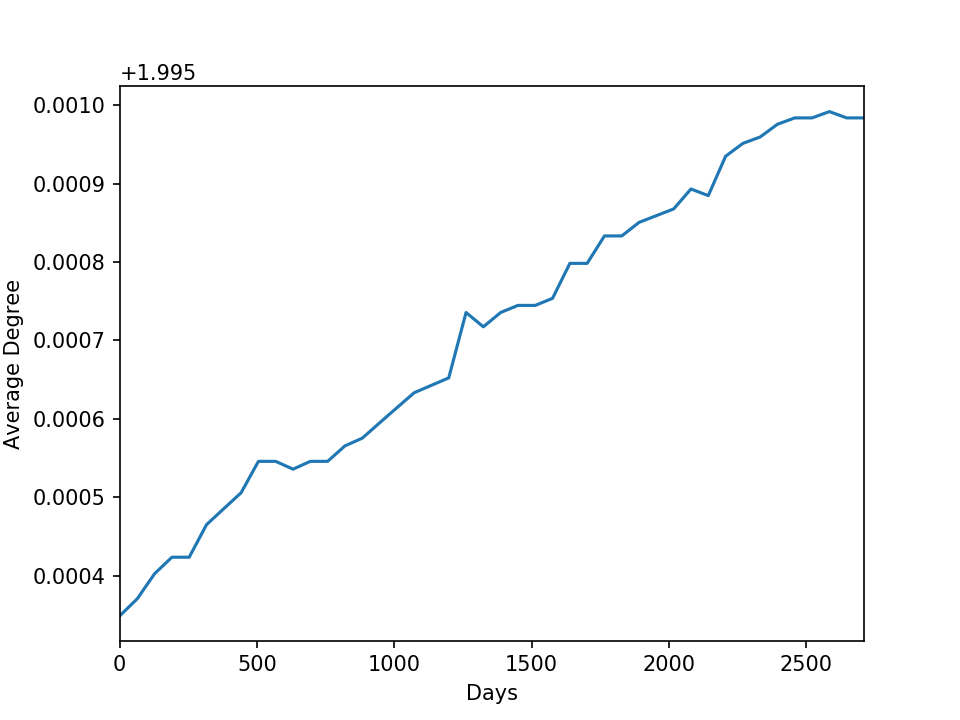

In [26]:
import matplotlib.pyplot as plt
%matplotlib notebook
avgdf=attribMST_df.groupby(by=['start'])['Degree'].mean()
avgdf.plot()
plt.xlabel('Days')
plt.ylabel('Average Degree')
plt.show()

In [27]:
attribMST_df.groupby(['ticker','Name','Sector'],as_index=False)['Degree'].sum().sort_values(['Sector','Degree'],ascending=False).groupby('Sector').head(5)[['ticker','Name','Degree','Sector']]

ticker                          Name  Degree                       Sector
488    XEL               Xcel Energy Inc   172.0                    Utilities
397    SCG                    SCANA Corp   165.0                    Utilities
14     AEP       American Electric Power   125.0                    Utilities
141    DTE                DTE Energy Co.   123.0                    Utilities
98     CMS                    CMS Energy   119.0                    Utilities
424      T                      AT&T Inc    79.0  Telecommunications Services
470     VZ        Verizon Communications    68.0  Telecommunications Services
283   LVLT        Level 3 Communications    58.0  Telecommunications Services
115    CTL               CenturyLink Inc    56.0  Telecommunications Services
191    FTR       Frontier Communications    26.0  Telecommunications Services
465    VNO          Vornado Realty Trust   141.0                  Real Estate
71     BXP             Boston Properties   137.0                  Real Estate
408    SPG      Simon Property Group Inc   134.0                  Real Estate
156    EQR            Equity Residential   124.0                  Real Estate
258    KIM                  Kimco Realty   124.0                  Real Estate
152    EMN              Eastman Chemical   133.0                    Materials
123     DD                Du Pont (E.I.)   120.0                    Materials
368    PPG                PPG Industries   117.0                    Materials
138    DOW                  Dow Chemical   113.0                    Materials
41     APD  Air Products & Chemicals Inc   105.0                    Materials
10     ADP     Automatic Data Processing   166.0       Information Technology
179   FISV                    Fiserv Inc   141.0       Information Technology
8      ADI          Analog Devices, Inc.   139.0       Information Technology
275   LLTC       Linear Technology Corp.   127.0       Information Technology
443    TXN             Texas Instruments   115.0       Information Technology
222    HON          Honeywell Int'l Inc.   229.0                  Industrials
246    ITW           Illinois Tool Works   158.0                  Industrials
137    DOV                   Dover Corp.   157.0                  Industrials
360     PH               Parker-Hannifin   145.0                  Industrials
162    ETN             Eaton Corporation   144.0                  Industrials
129    DHR                 Danaher Corp.   118.0                  Health Care
229   HSIC                  Henry Schein   116.0                  Health Care
492   XRAY               Dentsply Sirona   105.0                  Health Care
0        A      Agilent Technologies Inc   103.0                  Health Care
16     AET                     Aetna Inc   103.0                  Health Care
33     AMP          Ameriprise Financial   217.0                   Financials
436   TROW           T. Rowe Price Group   197.0                   Financials
357    PFG     Principal Financial Group   173.0                   Financials
60     BEN            Franklin Resources   170.0                   Financials
278    LNC              Lincoln National   169.0                   Financials
144    DVN            Devon Energy Corp.   145.0                       Energy
106    COP                ConocoPhillips   135.0                       Energy
39     APA            Apache Corporation   128.0                       Energy
312    MRO            Marathon Oil Corp.   126.0                       Energy
40     APC       Anadarko Petroleum Corp   118.0                       Energy
91      CL             Colgate-Palmolive   120.0             Consumer Staples
355    PEP                  PepsiCo Inc.   104.0             Consumer Staples
197    GIS                 General Mills    99.0             Consumer Staples
301    MKC               McCormick & Co.    99.0             Consumer Staples
358     PG              Procter & Gamble    94.0             Consumer Staples
405    SNA                

<IPython.core.display.Javascript object>


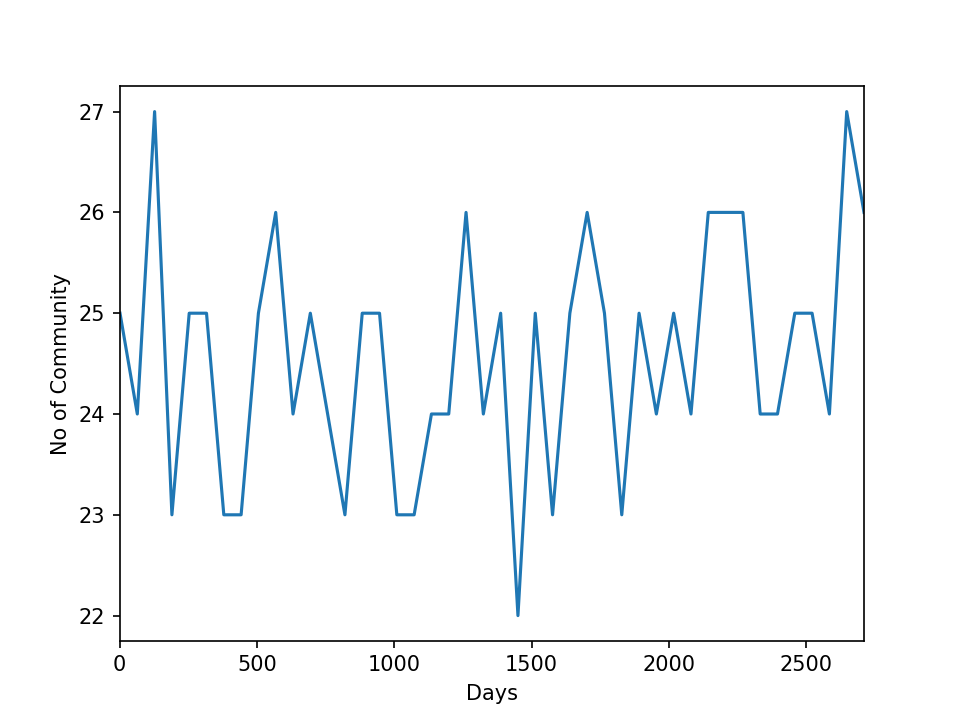

In [28]:
import matplotlib.pyplot as plt
%matplotlib notebook
cdf=attribMST_df.groupby(by=['start'])['Community'].nunique()
cdf.plot()
plt.xlabel('Days')
plt.ylabel('No of Community')
plt.show()

<IPython.core.display.Javascript object>


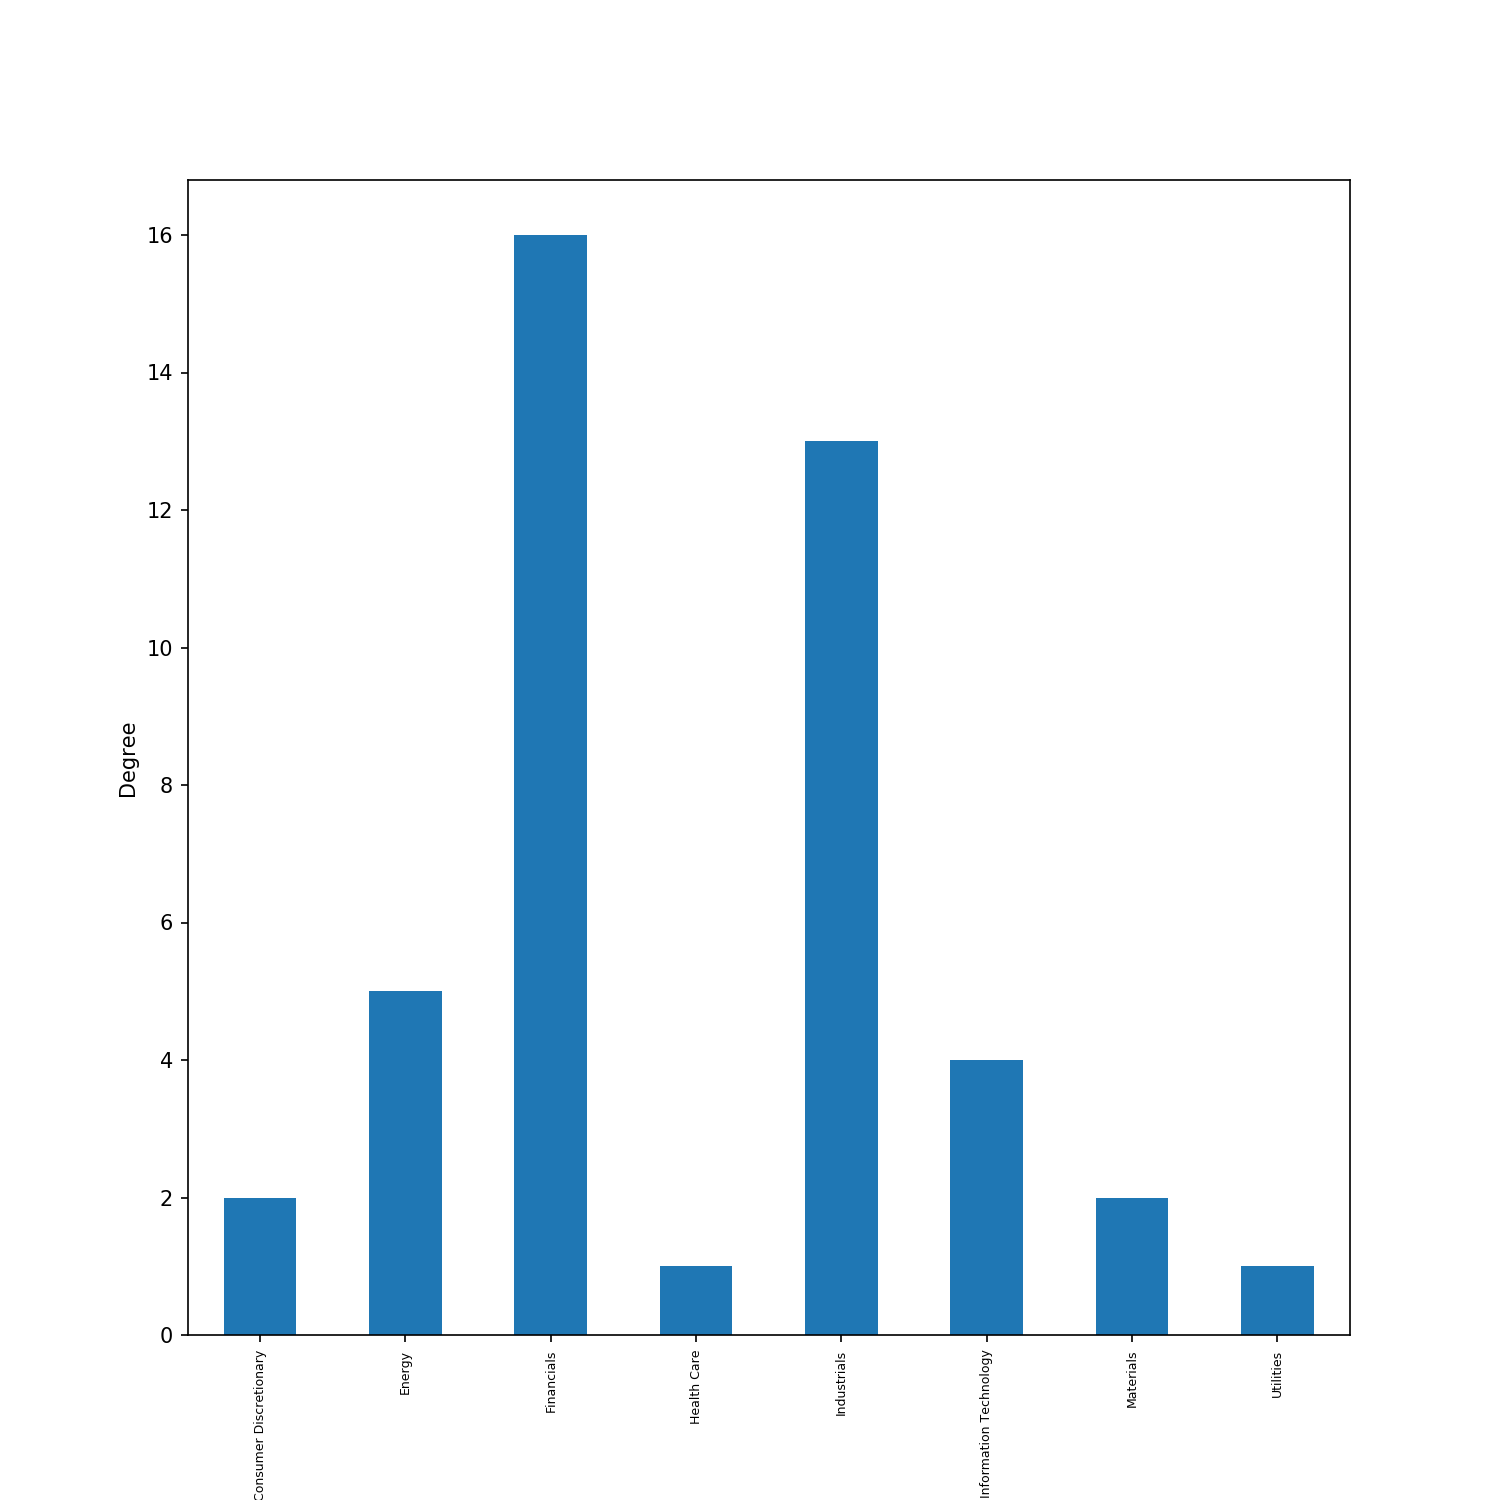

In [29]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(figsize=(10,10))
attribMST_df.sort_values(['start','Degree'],ascending=False).groupby(['start']).head(1).groupby(['Sector']).count()['ticker'].plot(kind='bar')
plt.xticks(rotation=90,fontsize=6)
plt.ylabel('Degree')

In [30]:
attribMST_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(3)[['start','ticker','Name','Betweeness','Sector']]

start ticker                                Name  Betweeness  \
2418    2710    BEN                  Franklin Resources    0.643912   
18946   2710    IVZ                        Invesco Ltd.    0.587119   
8534    2710    HON                Honeywell Int'l Inc.    0.469843   
2109    2647    BAC                Bank of America Corp    0.570293   
15779   2647    STI                      SunTrust Banks    0.547868   
17143   2647    UNM                          Unum Group    0.543381   
10642   2584    LNC                    Lincoln National    0.620890   
10950   2584     MA                     Mastercard Inc.    0.599080   
17362   2584    USB                        U.S. Bancorp    0.531026   
2767    2521  BRK.B                  Berkshire Hathaway    0.616538   
11565   2521    MMC                    Marsh & McLennan    0.543900   
2371    2521    BDX                    Becton Dickinson    0.525329   
1402    2458    AMP                Ameriprise Financial    0.656739   
11300   2458    MCO                        Moody's Corp    0.628310   
6317    2458    ETN                   Eaton Corporation    0.461892   
9409    2395     IR                  Ingersoll-Rand PLC    0.626474   
18941   2395    IVZ                        Invesco Ltd.    0.607665   
1313    2395    AMG       Affiliated Managers Group Inc    0.551360   
2104    2332    BAC                Bank of America Corp    0.638707   
11914   2332     MS                      Morgan Stanley    0.606573   
9804    2332    JPM                JPMorgan Chase & Co.    0.563262   
18017   2269    WFC                         Wells Fargo    0.674063   
3638    2269   CINF                Cincinnati Financial    0.543553   
2763    2269  BRK.B                  Berkshire Hathaway    0.490270   
9802    2206    JPM                JPMorgan Chase & Co.    0.681857   
14188   2206    PRU                Prudential Financial    0.598254   
15772   2206    STI                      SunTrust Banks    0.508999   
430     2143    ADP           Automatic Data Processing    0.679816   
11559   2143    MMC                    Marsh & McLennan    0.632657   
17399   2143    UTX                 United Technologies    0.475360   
...      ...    ...                                 ...         ...   
13326    568   PCAR                         PACCAR Inc.    0.598204   
6287     568    ETN                   Eaton Corporation    0.569651   
5319     568    DOV                         Dover Corp.    0.559414   
5890     505    EMN                    Eastman Chemical    0.737526   
1283     505    AMG       Affiliated Managers Group Inc    0.533917   
16493    505   TROW                 T. Rowe Price Group    0.484720   
17372    442    UTX                 United Technologies    0.709637   
7        442      A            Agilent Technologies Inc    0.596964   
5097     442    DIS             The Walt Disney Company    0.459287   
16491    379   TROW                 T. Rowe Price Group    0.630273   
17635    379    VNO                Vornado Realty Trust    0.537487   
10607    379    LNC                    Lincoln National    0.535814   
6459     316   EXPD                    Expeditors Int'l    0.629116   
13630    316    PFG           Principal Financial Group    0.565262   
10606    316    LNC                    Lincoln National    0.558014   
17149    253    UNP                       Union Pacific    0.608151   
12013    253    MTB                      M&T Bank Corp.    0.572488   
2071     253    BAC                Bank of America Corp    0.527765   
14684    190     RF             Regions Financial Corp.    0.646104   
2070     190    BAC                Bank of America Corp    0.575018   
2862     190    BXP                   Boston Properties    0.507529   
14683    127     RF             Regions Financial Corp.    0.657720   
793      127    AIG  American International Group, Inc.    0.550281   
10603    127    LNC                    Lincoln National    0.502400   
10602     64    LNC            

<IPython.core.display.Javascript object>


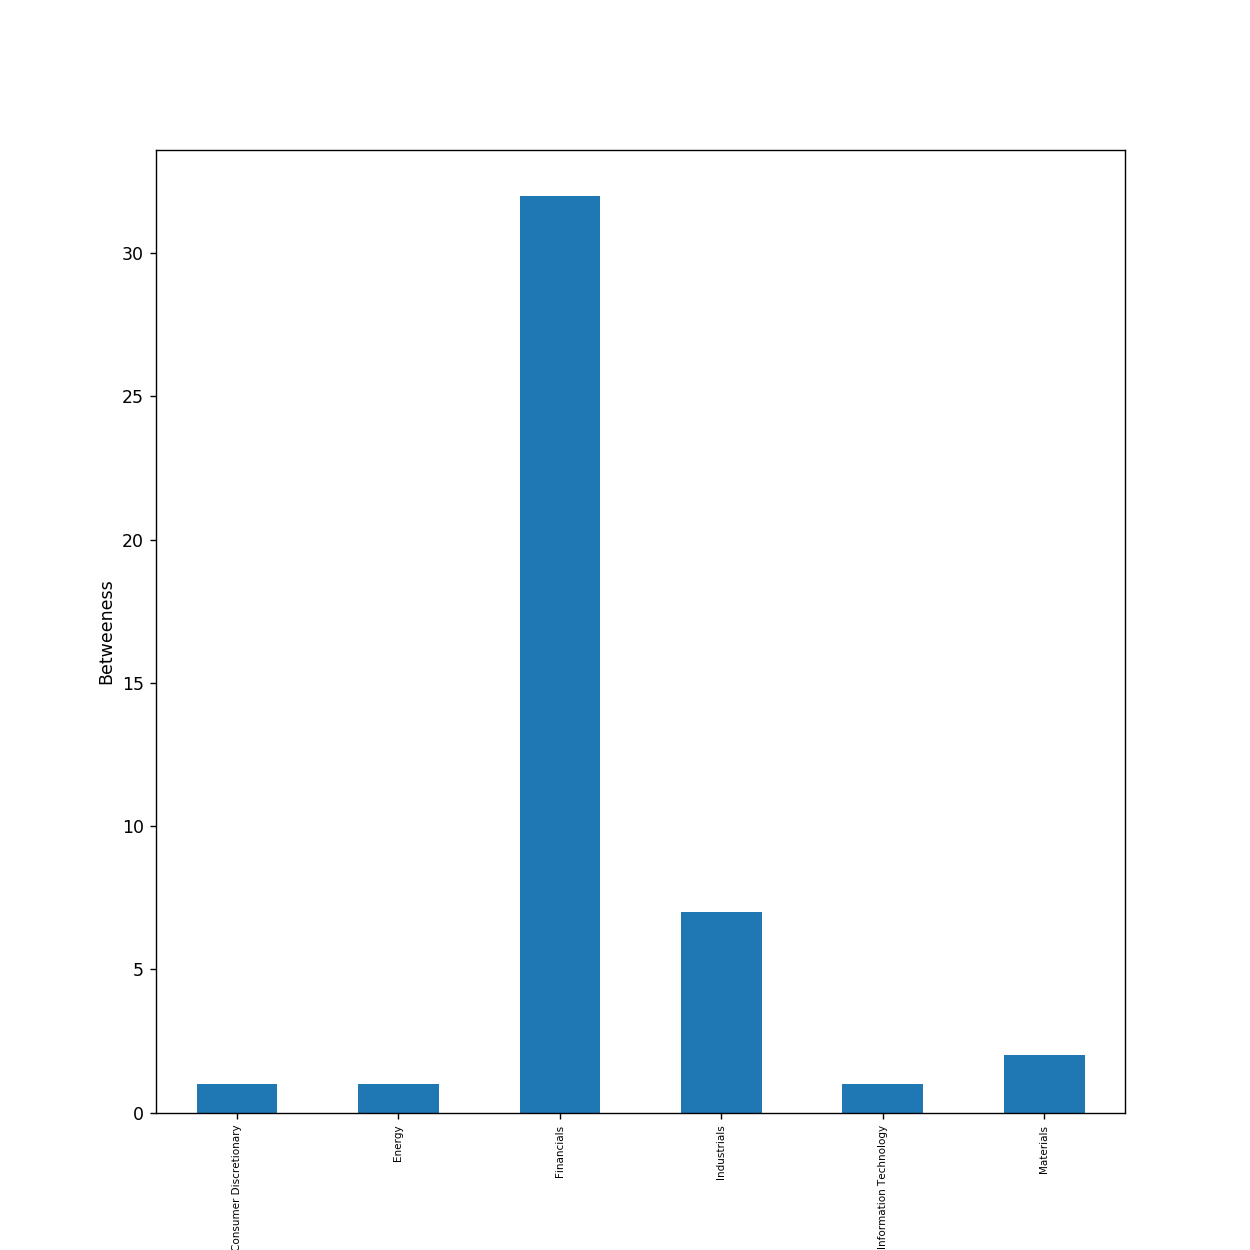

In [34]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(figsize=(10,10))
attribMST_df.sort_values(['start','Betweeness'],ascending=False).groupby(['start']).head(1).groupby(['Sector']).count()['ticker'].plot(kind='bar')
plt.xticks(rotation=90,fontsize=6)
plt.ylabel('Betweeness')

In [31]:
cmatrix = attribMST_df.groupby(by=['start','Community','ticker'])['ticker'].count().unstack()
cmatrix.fillna(0,inplace=True)
smatrix = attribMST_df.groupby(by=['Sector','ticker'])['ticker'].count().unstack()
smatrix.fillna(0,inplace=True)
smatrix[smatrix != 0] = 1
csmatrix=pd.concat([smatrix,cmatrix])
jval = {}
for idxs,rows  in smatrix.iterrows():
    xlist = []
    ylist = []
    for idxc,rowc in cmatrix.iterrows():
        x = [int(i) for i in rows]
        y = [int(i) for i in rowc]
        jc = (np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum()))
        if jc > 0.25:
            xlist.append(idxc[0])
            ylist.append(jc)
            print (str(idxs) + "-" + str(idxc) + str(jc))
    jval[idxs] = [xlist,ylist]

Consumer Discretionary-(253, 10)0.280898876404
Consumer Discretionary-(2395, 15)0.252873563218
Consumer Staples-(442, 19)0.260869565217
Consumer Staples-(1639, 9)0.285714285714
Consumer Staples-(1702, 25)0.365853658537
Consumer Staples-(1765, 17)0.404761904762
Consumer Staples-(1891, 11)0.421052631579
Consumer Staples-(1954, 8)0.34
Consumer Staples-(2017, 22)0.475
Consumer Staples-(2269, 12)0.260869565217
Consumer Staples-(2269, 25)0.25641025641
Consumer Staples-(2395, 10)0.301886792453
Consumer Staples-(2458, 23)0.315789473684
Consumer Staples-(2458, 24)0.32
Consumer Staples-(2521, 15)0.4
Consumer Staples-(2584, 8)0.441860465116
Energy-(1, 3)0.270833333333
Energy-(1, 10)0.485714285714
Energy-(64, 8)0.302325581395
Energy-(127, 8)0.270833333333
Energy-(190, 0)0.333333333333
Energy-(190, 13)0.357142857143
Energy-(316, 1)0.386363636364
Energy-(379, 12)0.459459459459
Energy-(379, 17)0.288888888889
Energy-(442, 0)0.439024390244
Energy-(442, 3)0.263157894737
Energy-(505, 7)0.282051282051
Ene

<IPython.core.display.Javascript object>


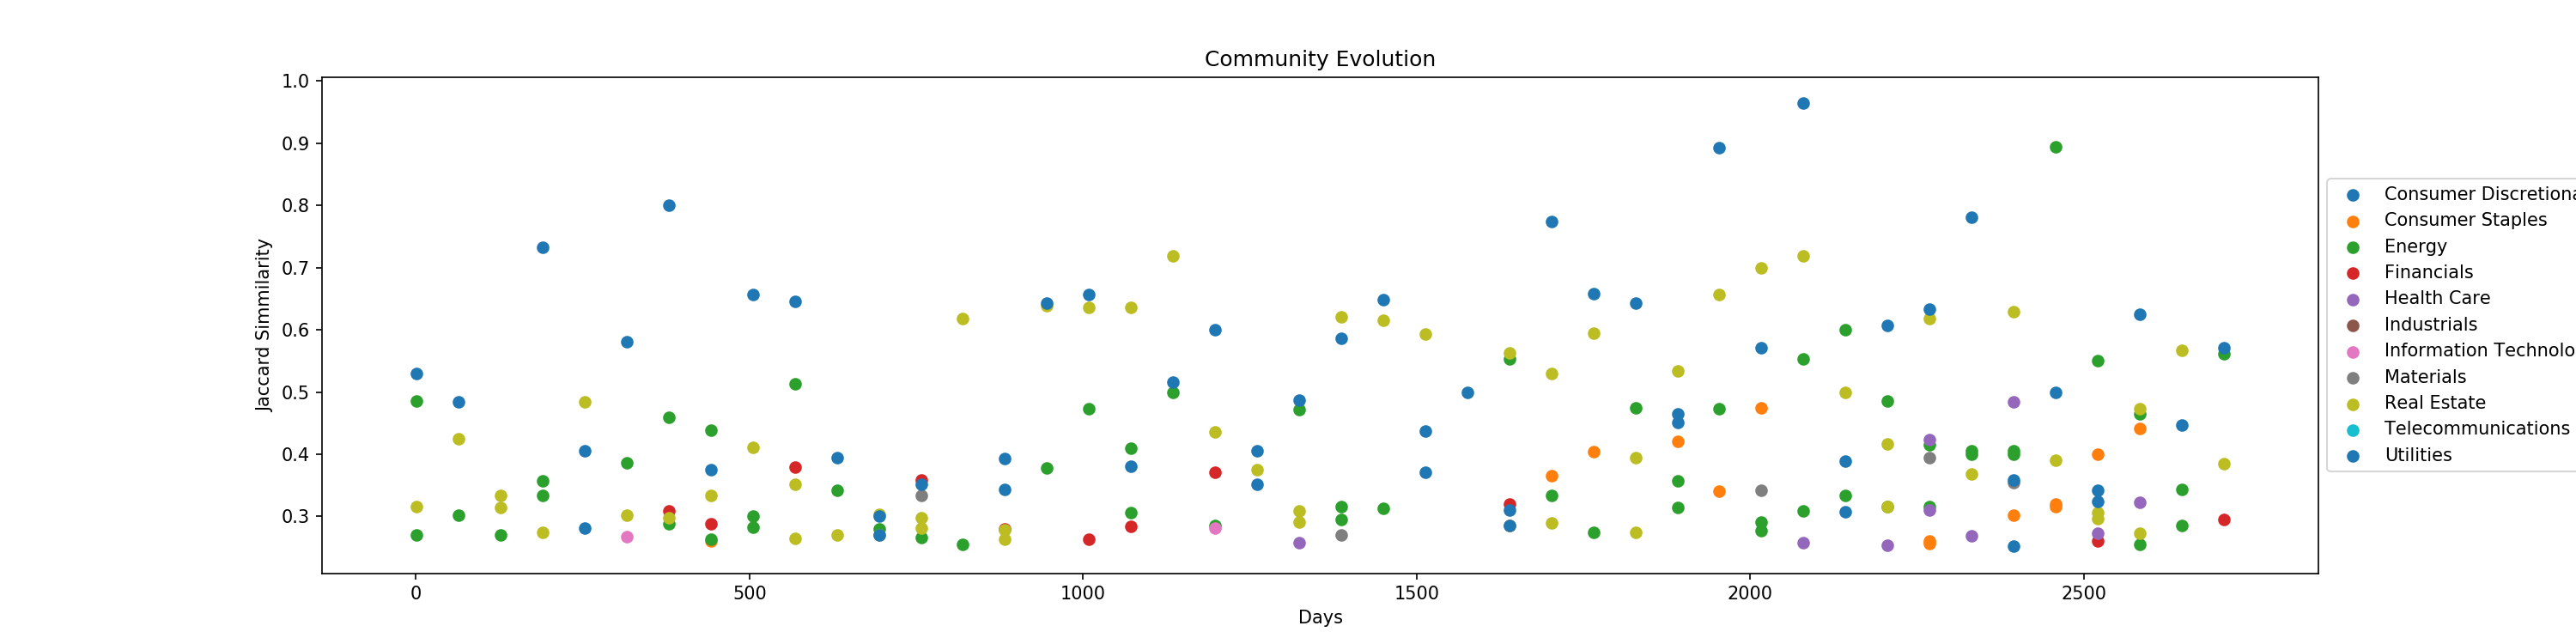

In [32]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(figsize=(20,5))
for key in jval:
    x = jval[key][0]
    y = jval[key][1]
    plt.scatter(x,y)
plt.legend(list(jval.keys()), loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Days')
plt.ylabel('Jaccard Simmilarity')
plt.title('Community Evolution')
plt.show()

<IPython.core.display.Javascript object>


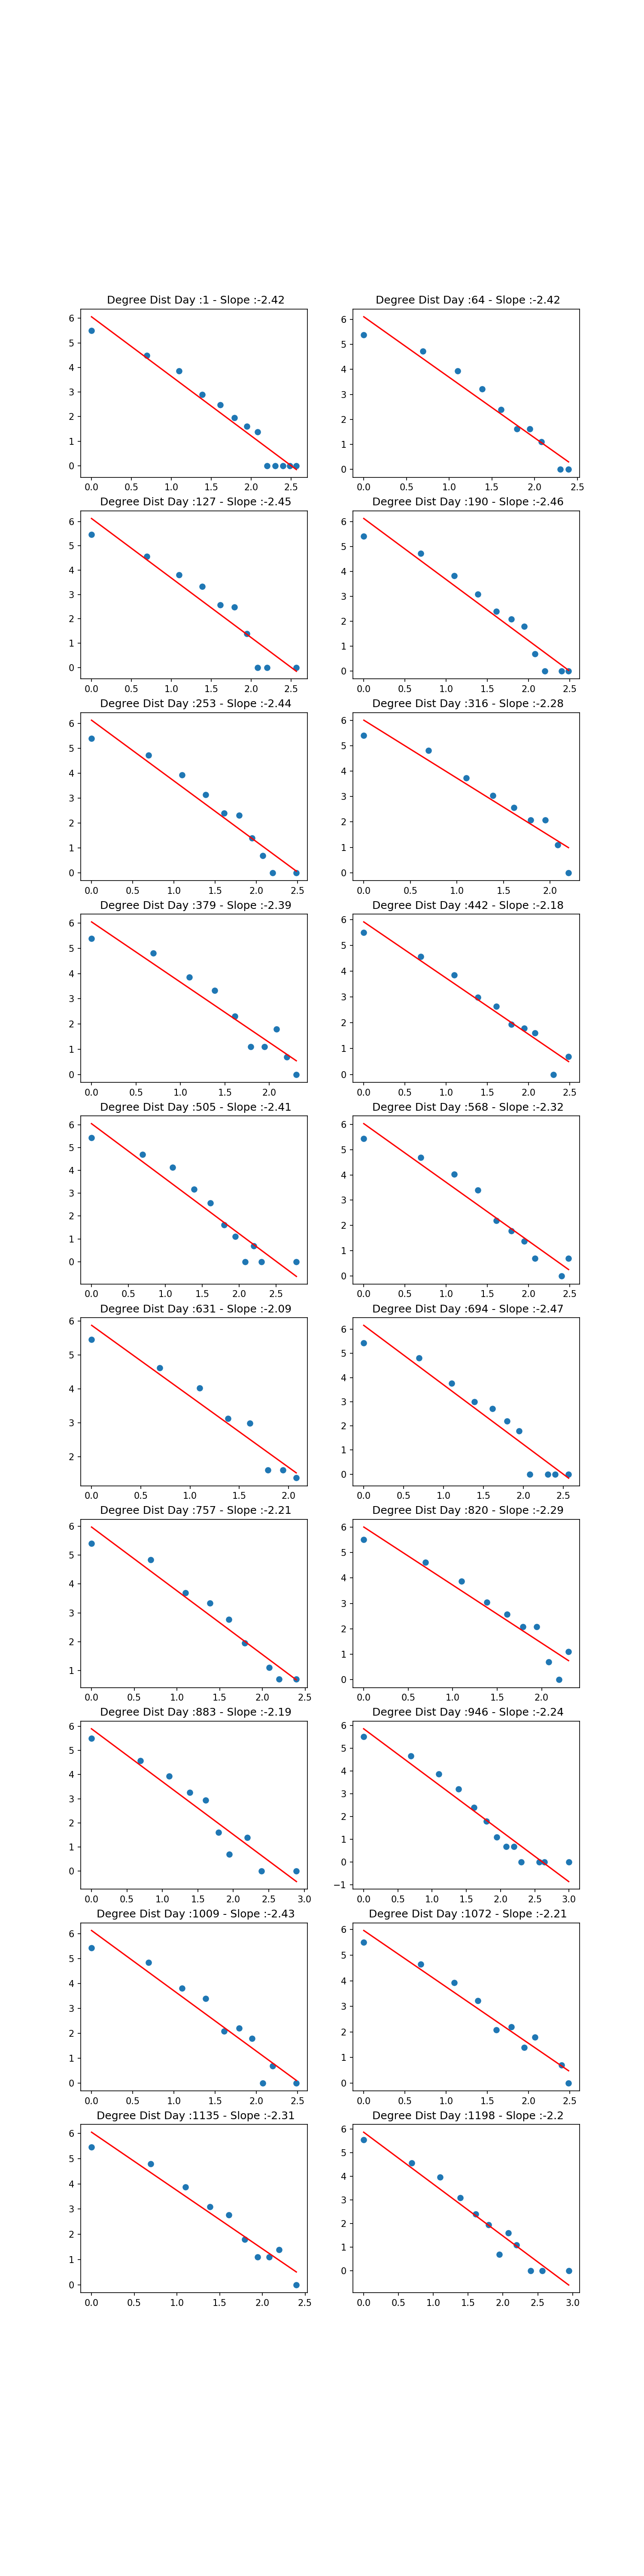

In [33]:
## Explore graph properties
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.stats import linregress
fig, ax = plt.subplots(nrows=10,ncols=2,figsize=(10, 40))
Y = 1
for row in ax:
    for col in row:
        degs = {}
        for n in GMST_dict[Y].nodes() :
            deg = GMST_dict[Y].degree(n)
            if deg not in degs.keys() :
                degs[deg] = 0
            degs[deg] += 1
        items = sorted(degs.items())
        x= [k for (k , v ) in items ]
        y= [ v for (k ,v ) in items ]
        xlog= np.array([np.log(k) for (k , v ) in items ])
        ylog= np.array([np.log(v) for (k ,v ) in items ])
        col.scatter(xlog, ylog)
        slope,intercept,rvalue,pvalue,stderr=linregress(xlog,ylog)
        col.plot(xlog, (slope * xlog + intercept), color='red')
        #ax.set_xscale( 'log' )
        #ax.set_yscale( 'log' )
        col.set_title ( " Degree Dist Day :" + str(Y) + " - Slope :" + str(round(slope,2) ))
        Y = Y + W
plt.show()

<IPython.core.display.Javascript object>


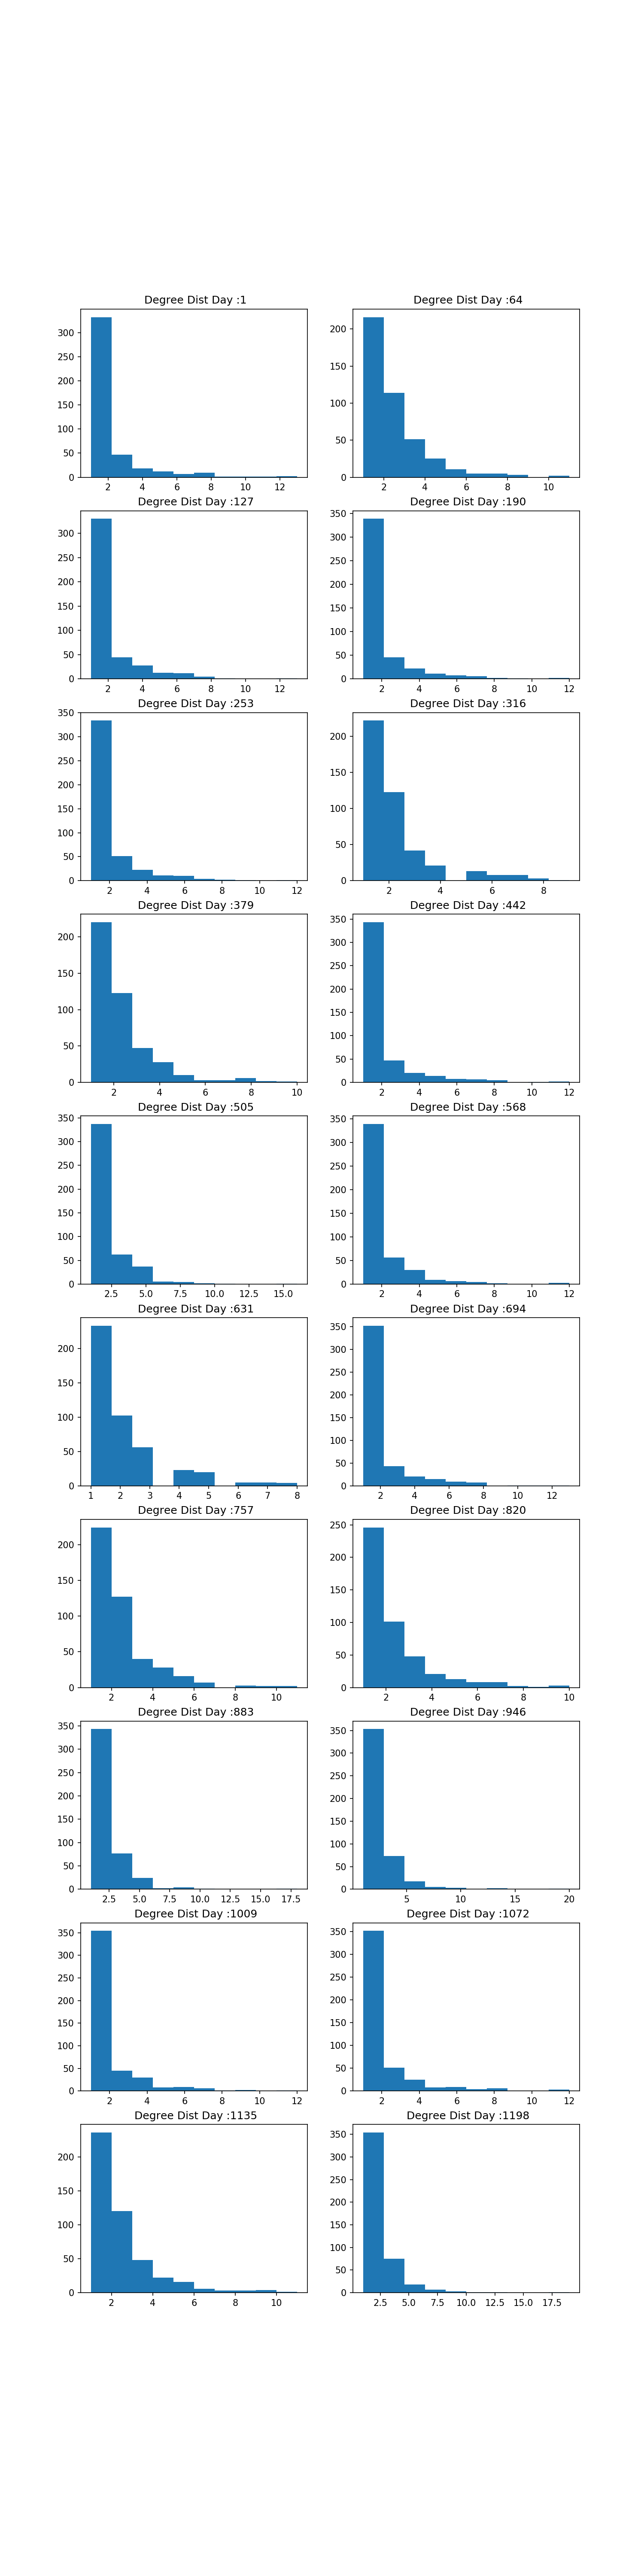

In [34]:
## Explore graph properties
import matplotlib.pyplot as plt
%matplotlib notebook
fig, ax = plt.subplots(nrows=10,ncols=2,figsize=(10, 40))
y = 1
for row in ax:
    for col in row:
        deg_dist = [v for k,v in nx.degree(GMST_dict[y]).items()]
        deg_dist.sort(reverse=True)
        pdf, bins, patch = col.hist(deg_dist, bins=10)
        col.set_title ( " Degree Dist Day :" + str(y) )
        y = y + W
plt.show()

In [45]:
# Constructing a graph
import networkx as nx
M=nx.MultiGraph()
for y in GMST_dict.keys():
    M.add_nodes_from(GMST_dict[y].nodes(data=True))
    M.add_edges_from(GMST_dict[y].edges(data=True))
nx.write_gexf(M,'data/price-MST-sp500.gexf')

In [46]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/price-MST-sp500.gexf')
root = tree.getroot()
for element in root.iter("{http://www.gexf.net/1.1draft}node"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child.remove(child[0])
        for y in GMST_dict.keys():
            T = GMST_dict[y]
            n = 0
            try:
                for att in T.node[noden]:
                    new = ET.Element("{http://www.gexf.net/1.1draft}attvalue")
                    new.set('for',str(n))
                    new.set('value',str(T.node[noden][att]))
                    new.set('start',str(y))
                    new.set('end',str(y+W-1))
                    child.append(new)
                    #print (T.node[noden][att])
                    n = n + 1
            except:
                continue
for element in root.iter("{http://www.gexf.net/1.1draft}edge"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child[i].set('start',str(element.attrib['start']))
            child[i].set('end',str(element.attrib['end']))
tree.write('data/price-MST-sp500-o.gexf')

In [ ]:
open("/tmp/test.svg") do f
   display("image/svg+xml", readstring(f))
end